# Laboratory 6

## Exercise 1
The number of particles emitted by a radioactive source during a fixed interval of time ($\Delta t = 10\text{s}$) follows a Poisson distribution on the parameter µ. The number of particles observed during consecutive time intervals is: $4, 1, 3, 1$ and $3$.

In [1]:
data = c(4,1,3,1,3)

### a) Suppose a uniform prior distribution for the parameter $\mu$ 
- determine and draw the posterior distribution for $\mu$, given the data
- evaluate mean, median and variance, both analytically and numerically in R

In [2]:
# Since there's no closed expression for the median, we'll resort to brute force
find_median <- function(dist,low,high){
    ## It is assumed that dist is normalized
    median <- (low+high)/2
    current.p <- integrate(dist,low,median)$value
    while(abs(current.p-0.5)>0.01){
        if(current.p<0.5){
            current.p <- current.p+integrate(dist,median,median+(high-median)/4)$value
            median <- median+(high-median)/4
        }
        else{
            current.p <- current.p+integrate(dist,median,median-(median-low)/4)$value
            median <- median-(median-low)/4
        }
    }
    return(median)
}


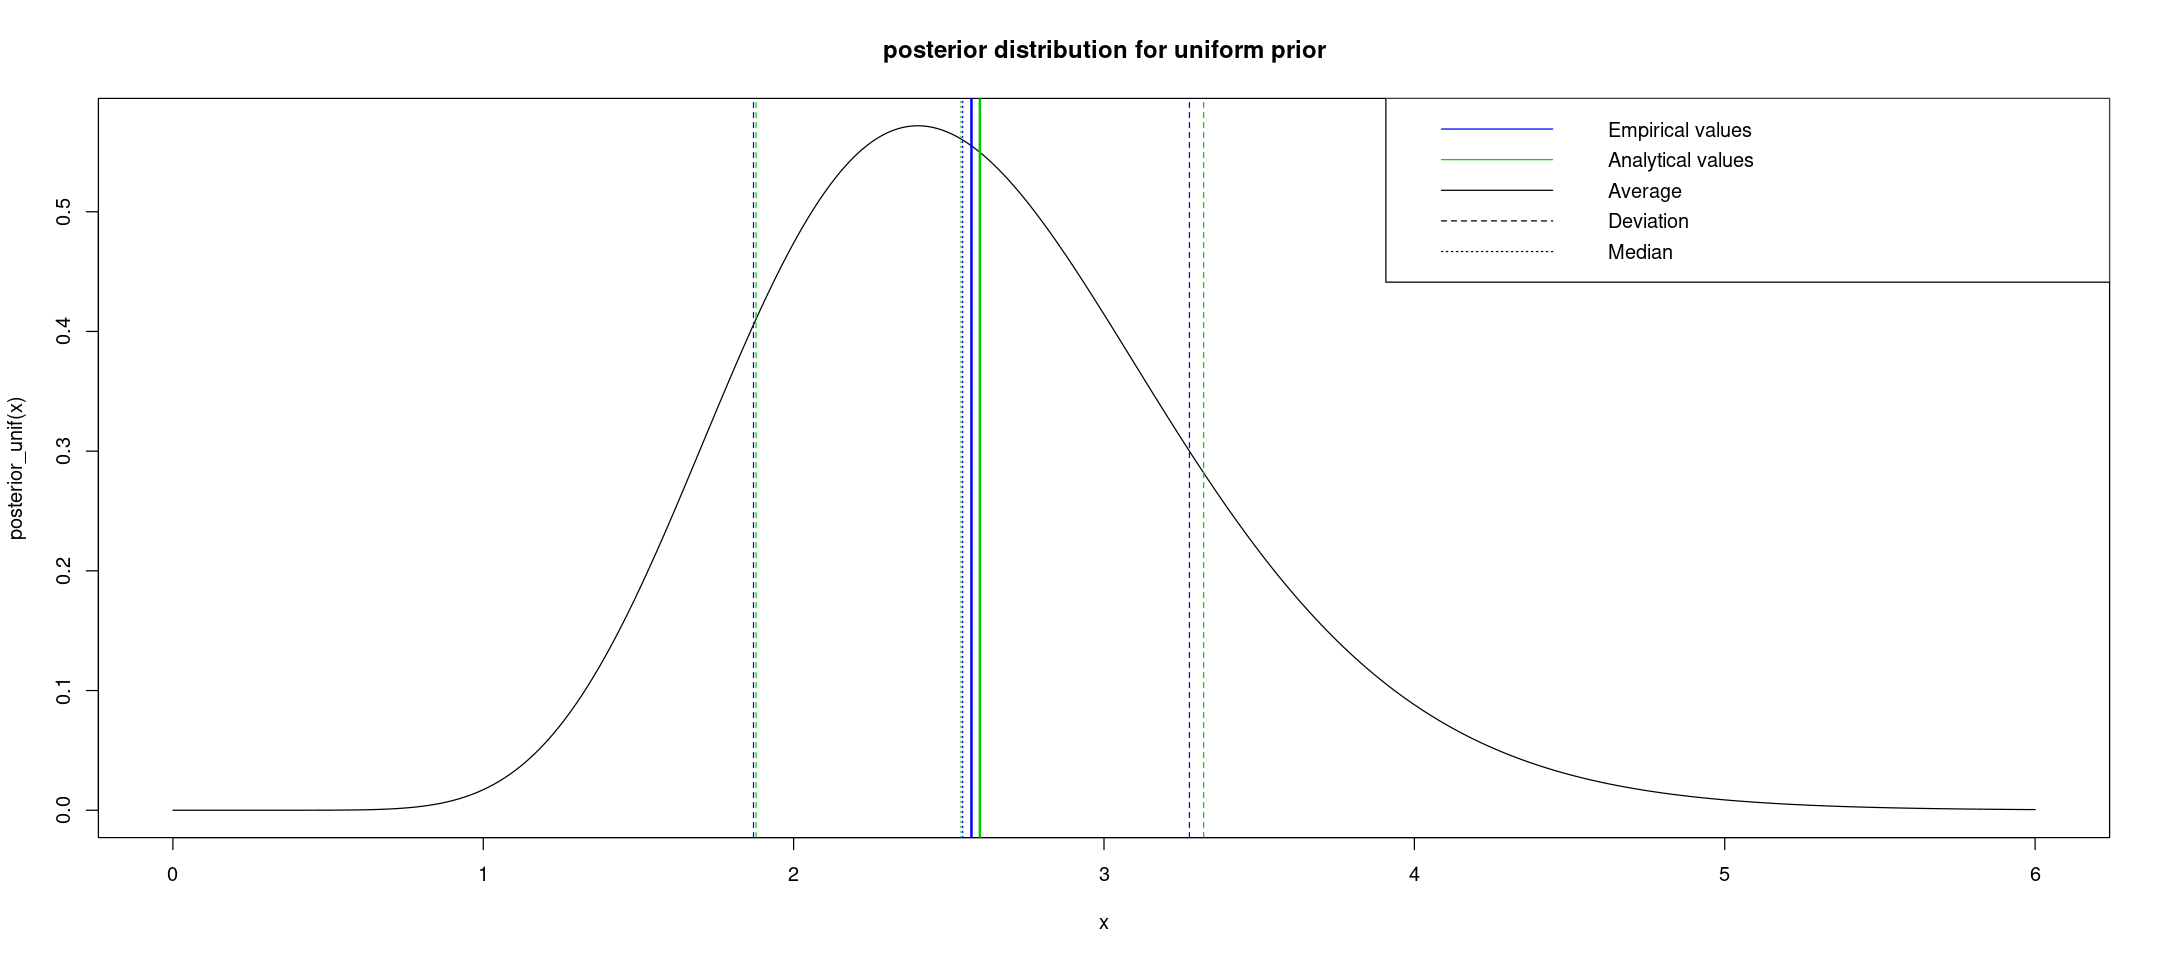

In [3]:
x <- seq(0,6,0.01)

options(repr.plot.width=18, repr.plot.height=8)

# The product of poisson distributions becomes a gamma function:
#likelihood <- function(data,mu){dgamma(mu,sum(data)+1,length(data))}
alpha_u <- sum(data)+1; lambda_u <- length(data)
posterior_unif <- function(mu){dgamma(mu,alpha_u,lambda_u)}
plot(x,posterior_unif(x), type = 'l', main = 'posterior distribution for uniform prior')


## Measuring statistical properties
sampli <- rgamma(1000,alpha_u,lambda_u)

u_avg <- mean(sampli)
u_var <- mean(sampli**2)-u_avg**2
u_dev <- sqrt(u_var)
u_med <- median(sampli)
abline(v = c(u_avg,u_avg-u_dev,u_avg+u_dev,u_med),col = 4, lwd = c(2,1,1,1), lty = c(1,2,2,9))

u_mu <- alpha_u/lambda_u
u_sigsq <- alpha_u/lambda_u**2
u_sig <- sqrt(u_sigsq)
u_xhat <- find_median(posterior_unif,0,6)
abline(v = c(u_mu,u_mu-u_sig,u_mu+u_sig,u_xhat),col = 3, lwd = c(2,1,1,1), lty = c(1,2,2,9))


measures <- c("Empirical values","Analytical values", "Average", "Deviation", "Median")
legend("topright",legend = measures, col =c(4,3,1,1,1,1), lty = c(1,1,1,2,9))

### b) Suppose a Jeffreys prior for the parameter µ
 - determine and draw the posterior distribution for $\mu$, given the data
 - evaluate mean, median and variance, both analytically and numerically in R

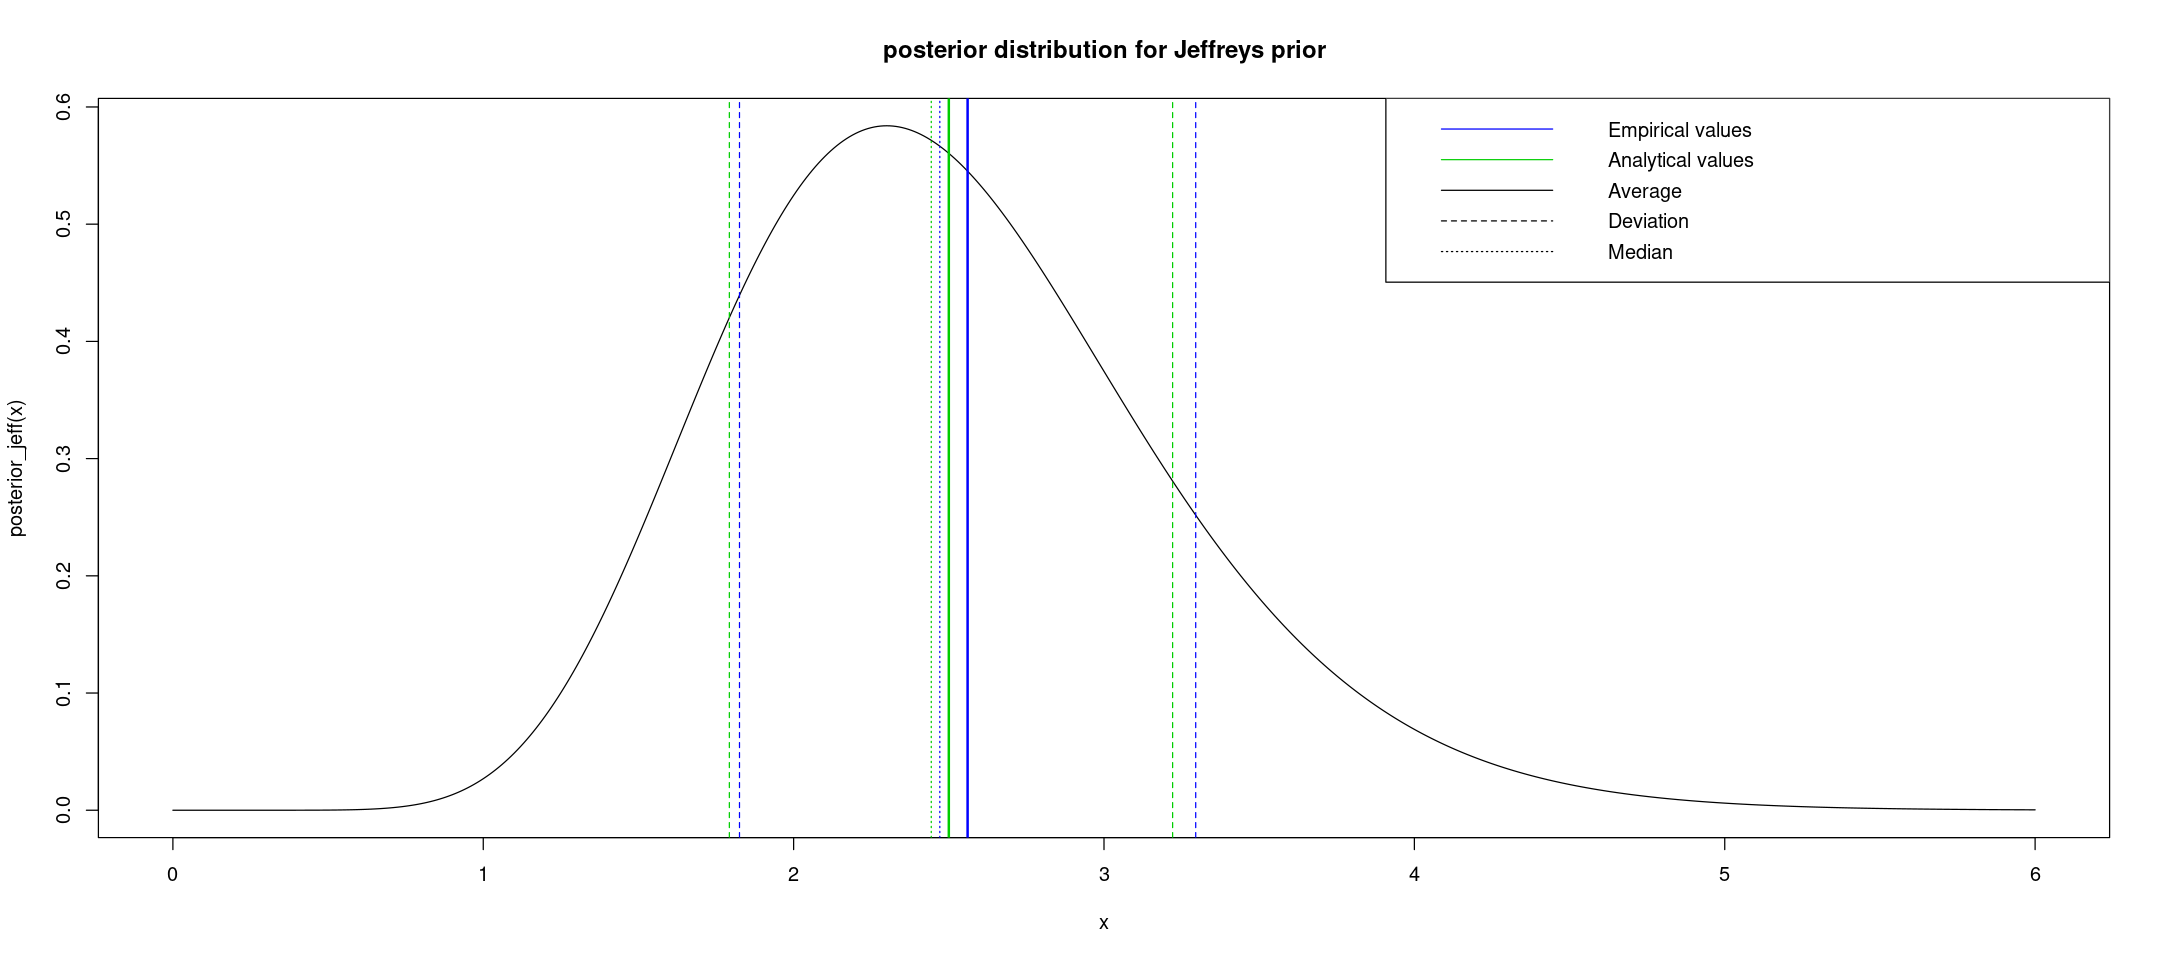

In [4]:
# when using a jeffreys prior, the posterior distribution results in a gamma function
alpha_j <- sum(data)+1/2; lambda_j <- length(data)
posterior_jeff <- function(mu){dgamma(mu,alpha_j,lambda_j)}
plot(x, posterior_jeff(x), type = 'l', main = 'posterior distribution for Jeffreys prior')

## 
sampli <- rgamma(1000,alpha_j,lambda_j)

j_avg <- mean(sampli)
j_var <- mean(sampli**2)-j_avg**2
j_dev <- sqrt(j_var)
j_med <- median(sampli)
abline(v = c(j_avg,j_avg-j_dev,j_avg+j_dev, j_med),col = 4, lwd = c(2,1,1,1), lty = c(1,2,2,9))

j_mu <- alpha_j/lambda_j
j_sigsq <- alpha_j/lambda_j**2
j_sig <- sqrt(j_sigsq)
j_xhat <- find_median(posterior_jeff,0,6)
abline(v = c(j_mu,j_mu-j_sig,j_mu+u_sig, j_xhat),col = 3, lwd = c(2,1,1,1), lty = c(1,2,2,9))

measures <- c("Empirical values","Analytical values", "Average", "Deviation", "Median")
legend("topright",legend = measures, col =c(4,3,1,1,1,1), lty = c(1,1,1,2,9))

### c) evaluate a 95% credibility interval for the results obtained with both priors. Compare the result with that obtained using a normal approximation for the posterior distribution, with the same mean and standard deviation

In [5]:
find_ci <- function(post,c.i.,low,high){
    x <- seq(low,high,0.01)
    best_x <- x[which.max(post(x))]
    low_c <- max(0.5*best_x,low)#(low+best_x)/2
    high_c <- min(1.5*best_x,high)#(high+best_x)/2
    c <- integrate(post,low_c,high_c)$value
    i <- 0
    while(abs(c-c.i.) > 0.001){
        # The reference value is the best_x if the confidence is higher,
        # Otherwise, it is the bound a little displaced
        # Therefore, the interval extremes may go closer to best_x
        # if the confidence is higher than desired
        # and further from it otherwise
        ref_low <- max(low_c-(best_x-low_c)/10,low)*(c<c.i.)+best_x*(c>c.i.)
        ref_high <- min(high_c+(high_c-best_x)/10,high)*(c<c.i.)+best_x*(c>c.i.)
        #ref_high <- ifelse(ref_low ==low,high,best_x)
        
        # we randomly choose whether to modify both or a single one of the bounds
        # The most likely scenario (18/20) is that both extremes are moved.
        # It is equally likely that either of the bounds is the only one modified (1/20)
        modify <- sample(20,1)
        low_c <- (modify < 20)*(ref_low + low_c)/2+(modify == 20)*low_c
        high_c <- (modify > 1)*(ref_high + high_c)/2+(modify == 1)*high_c
        c <- integrate(post,low_c,high_c)$value
    }
    return(c(low_c,high_c,best_x))
}


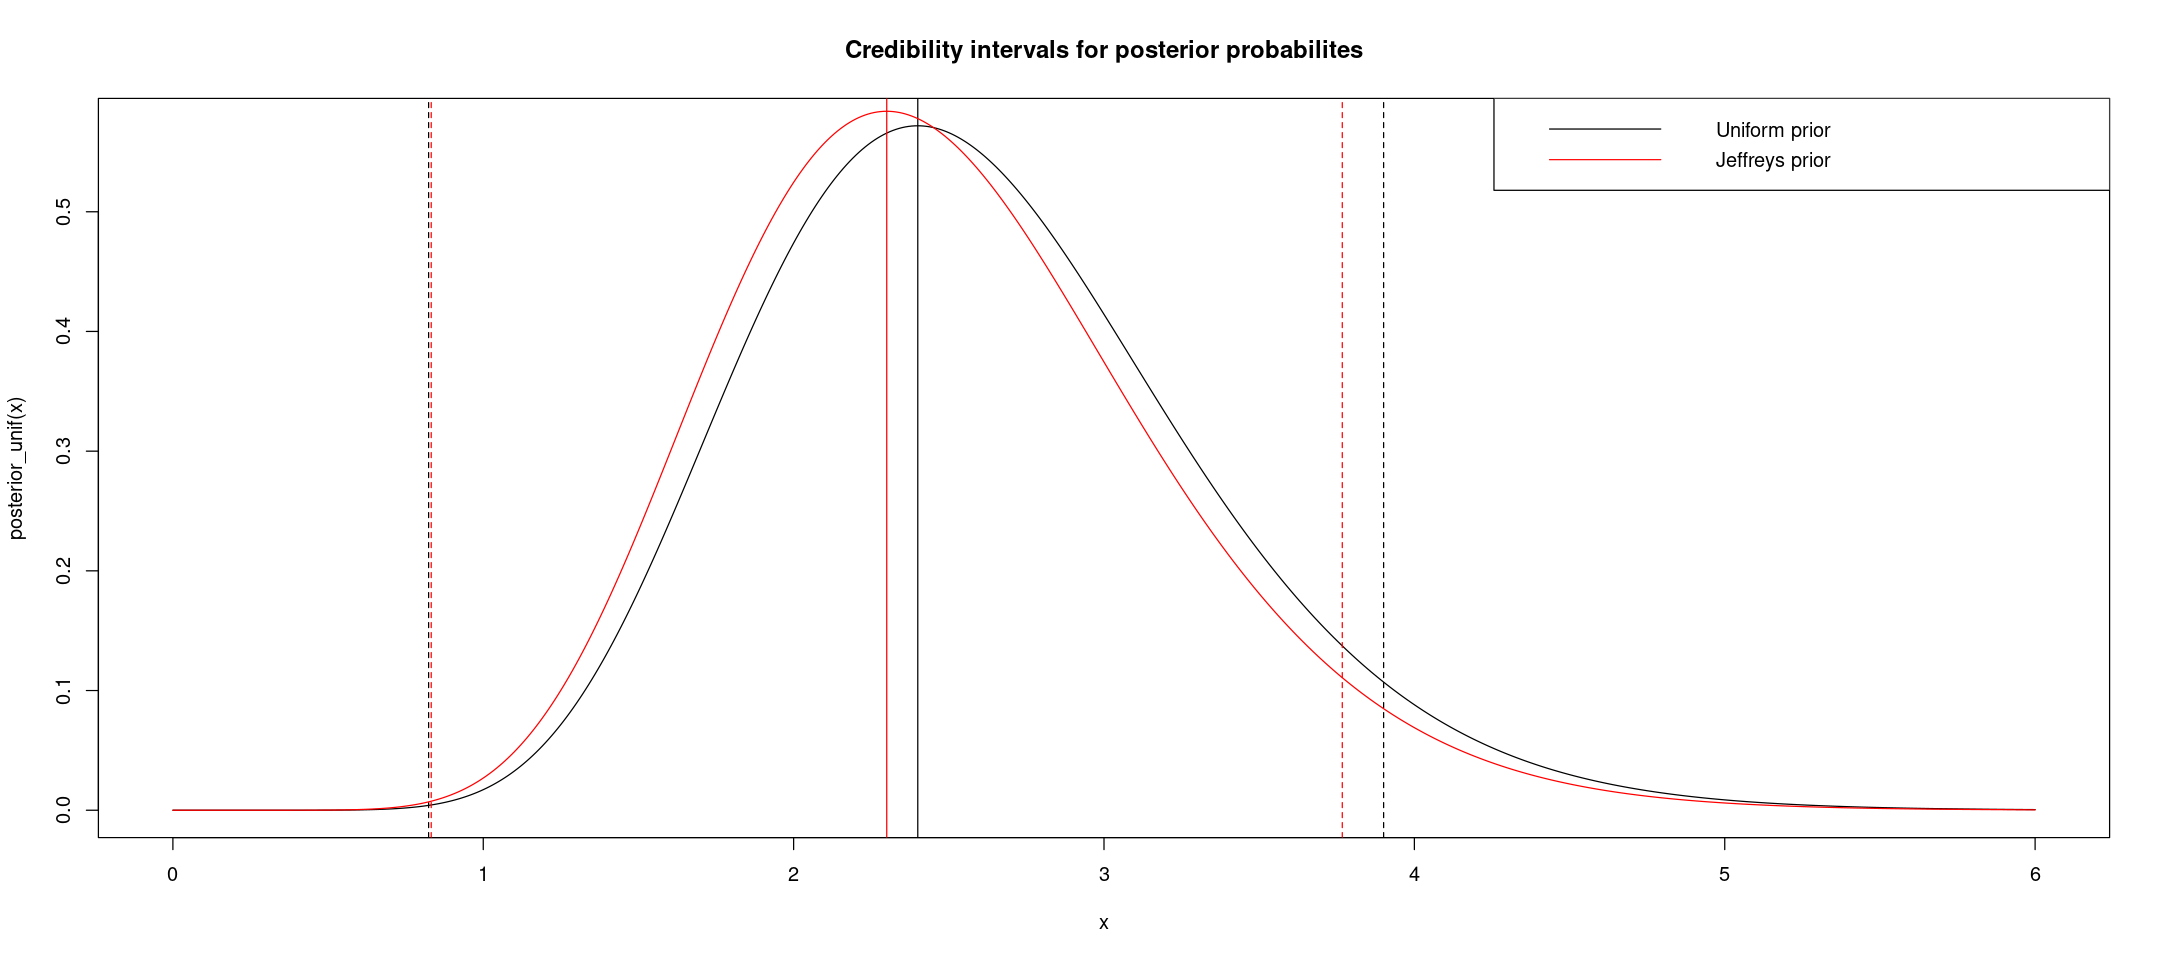

In [6]:
jeff_int <- find_ci(posterior_jeff,0.95,0,6)
unif_int <- find_ci(posterior_unif,0.95,0,6)
plot(x,posterior_unif(x), type = 'l', main = 'Credibility intervals for posterior probabilites', col = 1)
abline(v=unif_int, lty = c(2,2,1), col = 1)
lines(x,posterior_jeff(x), type = 'l', col = 2)
abline(v=jeff_int,lty = c(2,2,1), col = 2)
legend("topright",legend = c("Uniform prior","Jeffreys prior"), col =1:2, lty = 1)

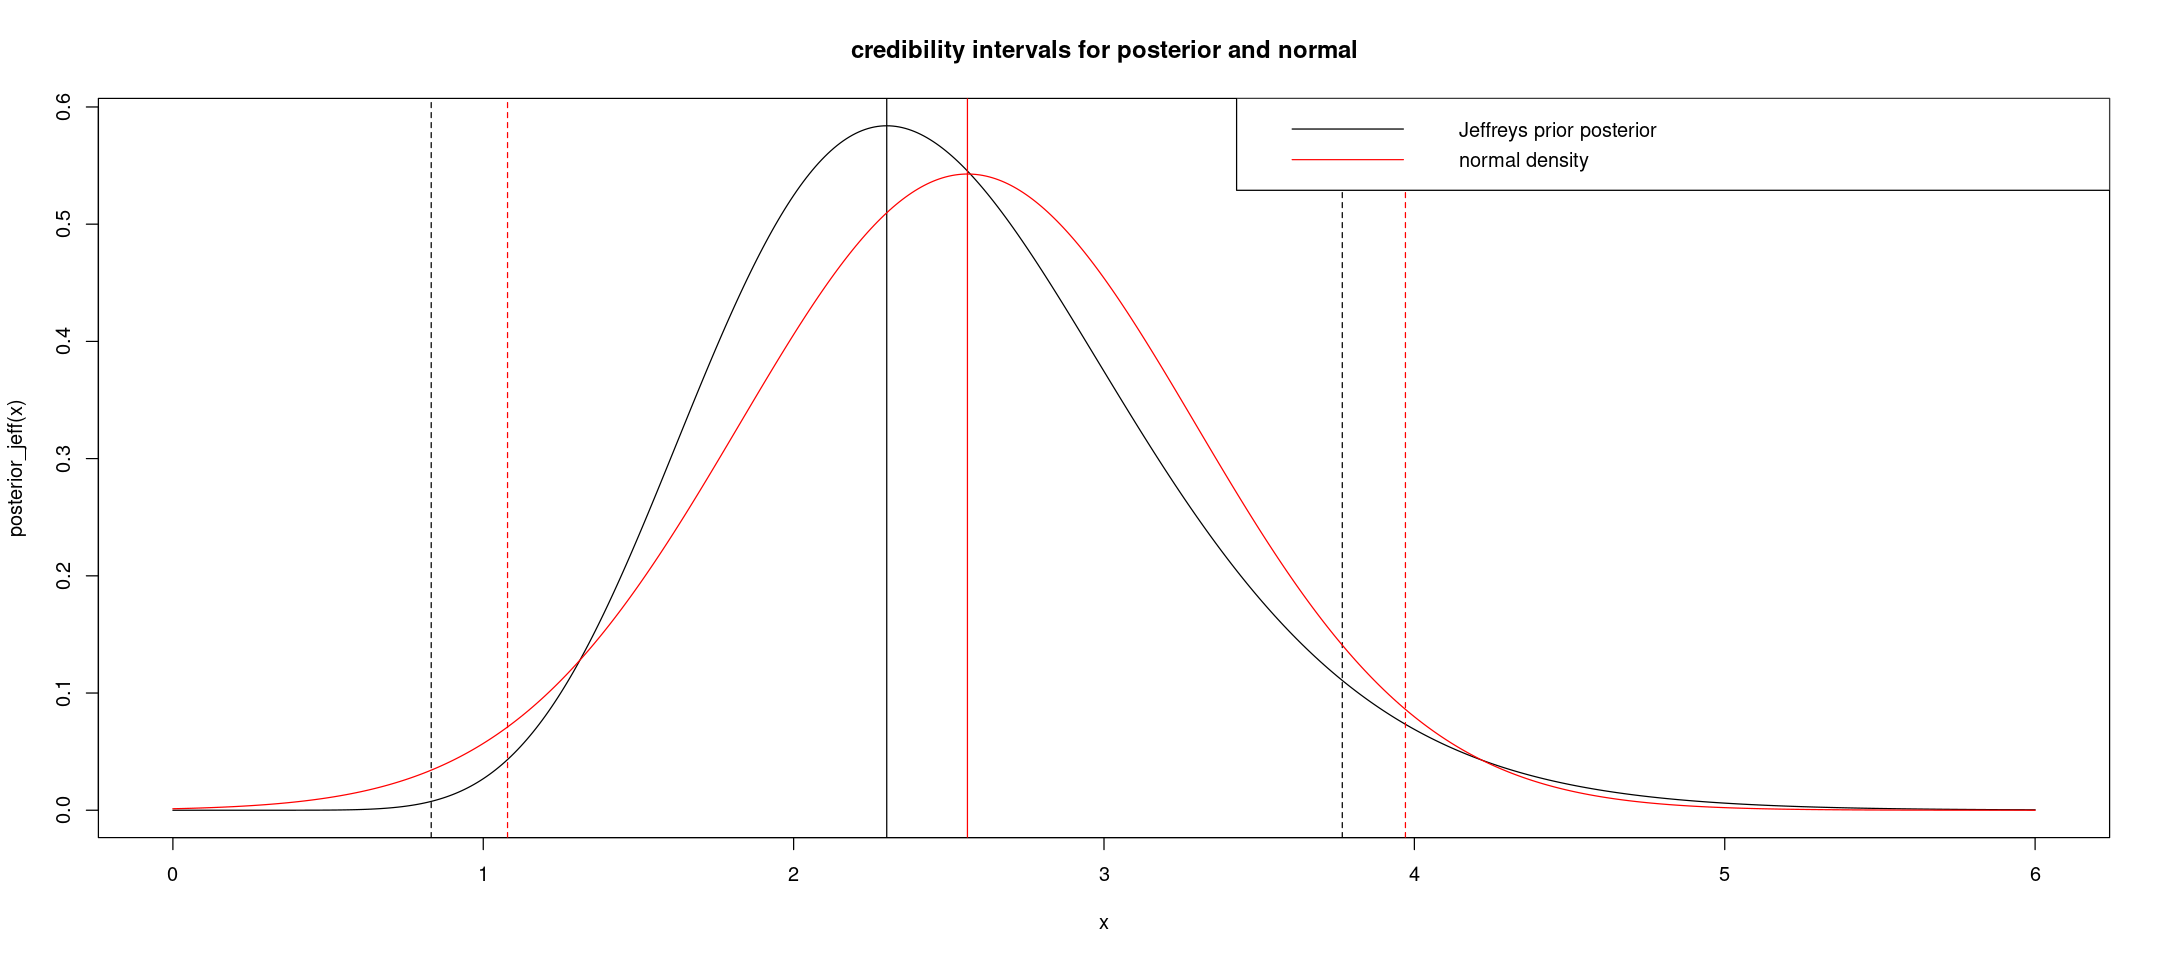

In [7]:
jeff_norm <- function(x){dnorm(x,j_avg, j_dev)}
jeff_norm_int <- find_ci(jeff_norm,0.95,0,6)
plot(x,posterior_jeff(x), type = 'l', main = 'credibility intervals for posterior and normal', col = 1)
abline(v=jeff_int, lty = c(2,2,1), col = 1)
lines(x,jeff_norm(x), type = 'l', col = 2)
abline(v=jeff_norm_int,lty = c(2,2,1), col = 2)
legend("topright",legend = c("Jeffreys prior posterior", "normal density"), col =1:2,lty = 1)

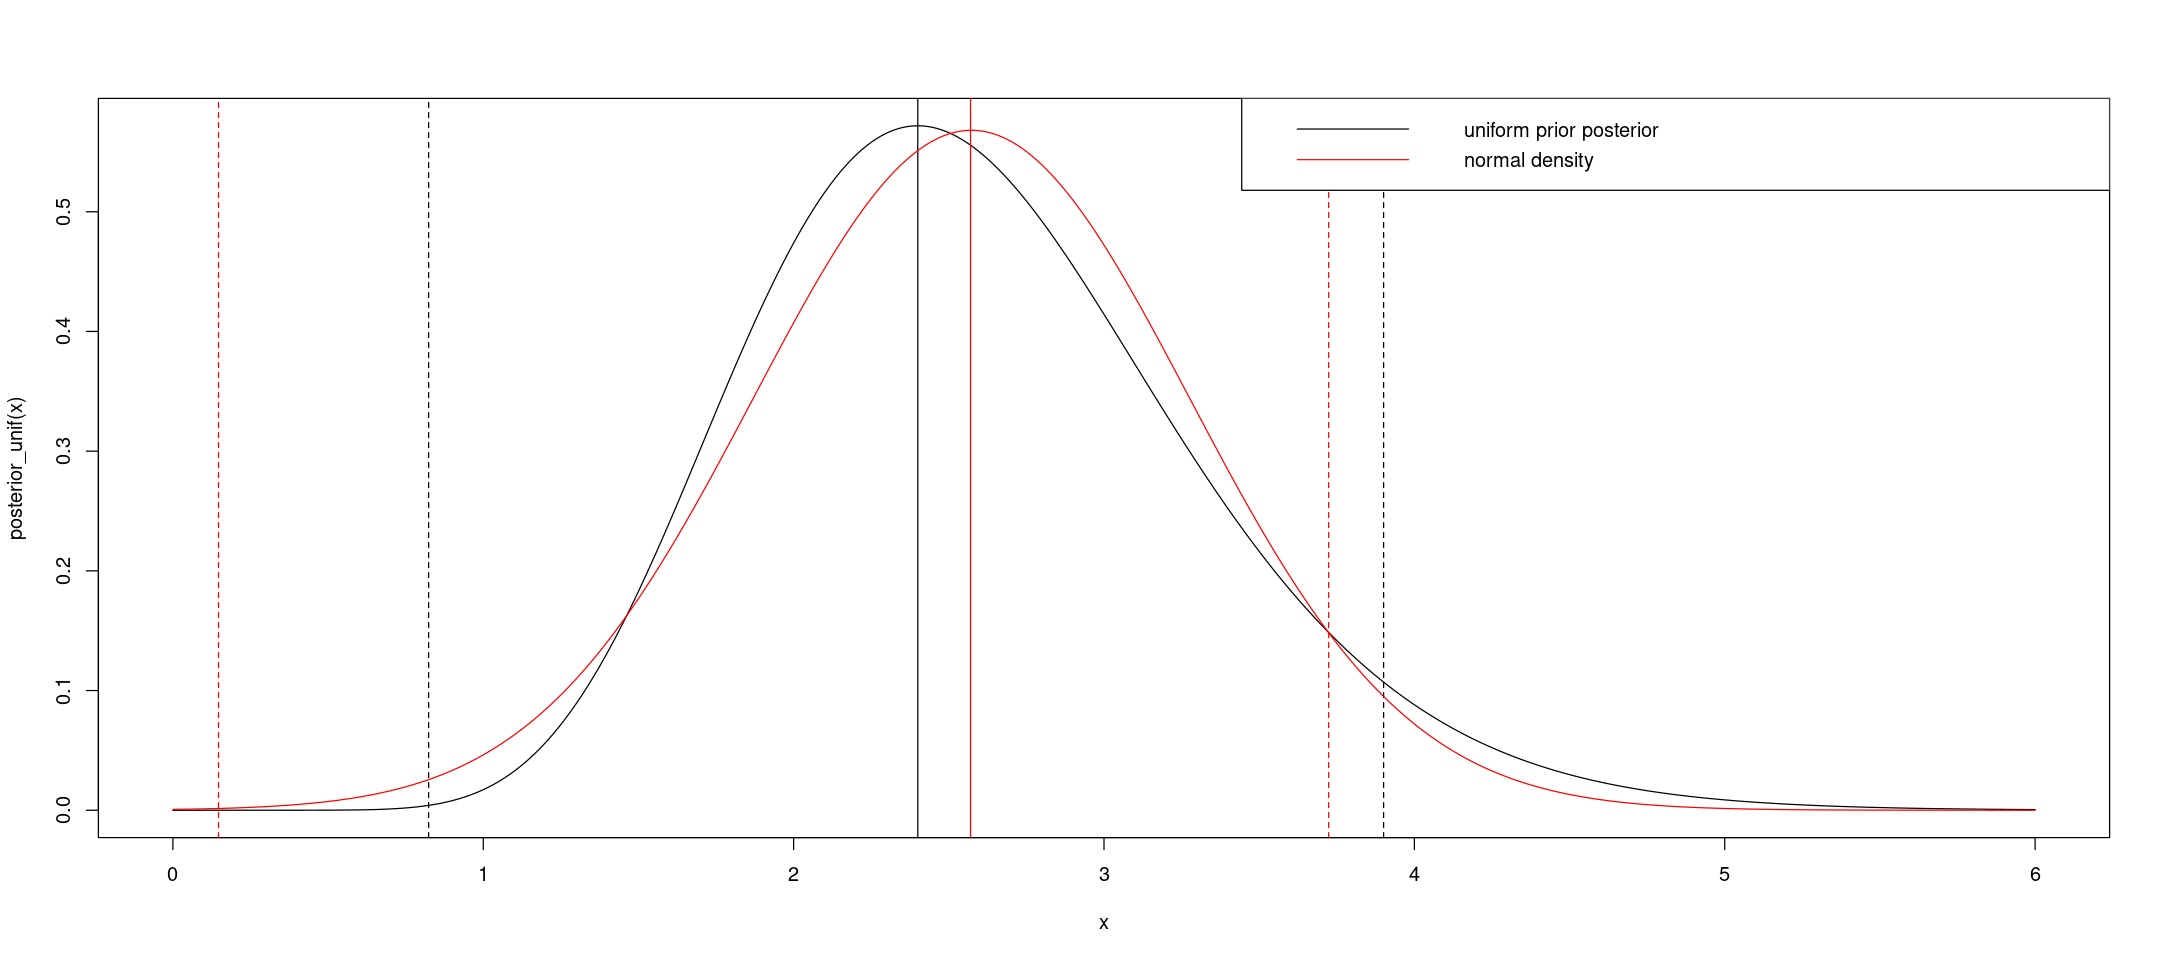

In [8]:
unif_norm <- function(x){dnorm(x,u_avg, u_dev)}
unif_norm_int <- find_ci(unif_norm,0.95,0,6)
plot(x,posterior_unif(x), type = 'l', col = 1)
abline(v=unif_int, lty = c(2,2,1), col = 1)
lines(x,unif_norm(x), type = 'l', col = 2)
abline(v=unif_norm_int,lty = c(2,2,1), col = 2)
legend("topright",legend = c("uniform prior posterior", "normal density"), col =1:2, lty = 1)

## Exercise 2
- Given the problem of the lightouse discussed last week, study the case in which both the position along the shore ($\alpha$) and the distance out at sea ($\beta$) are unknown

We want to study $p(\alpha,\beta|\{x_k\})$, which by Bayes' rule:
$$
\begin{align}
p(\alpha,\beta|\{x_k\}) &\propto p(\{x_k\}|\alpha,\beta)p(\alpha,\beta)\\
&\propto p(\{x_k\}|\alpha,\beta)p(\alpha)p(\beta)
\end{align}
$$
because $\alpha$ and $\beta$ are independent(?).

Furthermore, from a uniform distribution for the azimuth angle and some trigonometrical relations, we obtain:
$$
p(x_k|\alpha,\beta) = \frac{1}{\pi}\frac{\beta}{\beta^2+(x_k-\alpha)^2}
$$

Every observation is independent, thus:
$$
p(\alpha,\beta|\mathbf{x}) \propto p(\alpha)p(\beta)\prod_k\left(\frac{1}{\pi}\frac{\beta}{\beta^2+(x_k-\alpha)^2}\right)\\
\log p(\alpha,\beta|\mathbf{x}) \propto  \log C-\sum_k\log\left(\beta^2+(x_k-\alpha)^2\right)+N\log\beta\\
$$
where the priors were absorbed by the constant $C$, as we assumed uniform distributions for both parameters.


In [9]:
set.seed(123)
beta.true <- 10
alpha.true <- 10
theta <- runif(100,-pi/2,pi/2)
data <- beta.true*tan(theta)+alpha.true

In [10]:
logpost <- function(data, alpha, beta){
    length(data)*log(beta)-sum(log(beta**2+(data-alpha)**2))
}

In [11]:
beta <- seq(0,20,0.05)
alpha <- seq(0,20,0.05)

z <- outer(alpha,beta,Vectorize(function(x,y){logpost(data,x,y)}))
z <- z-max(z)

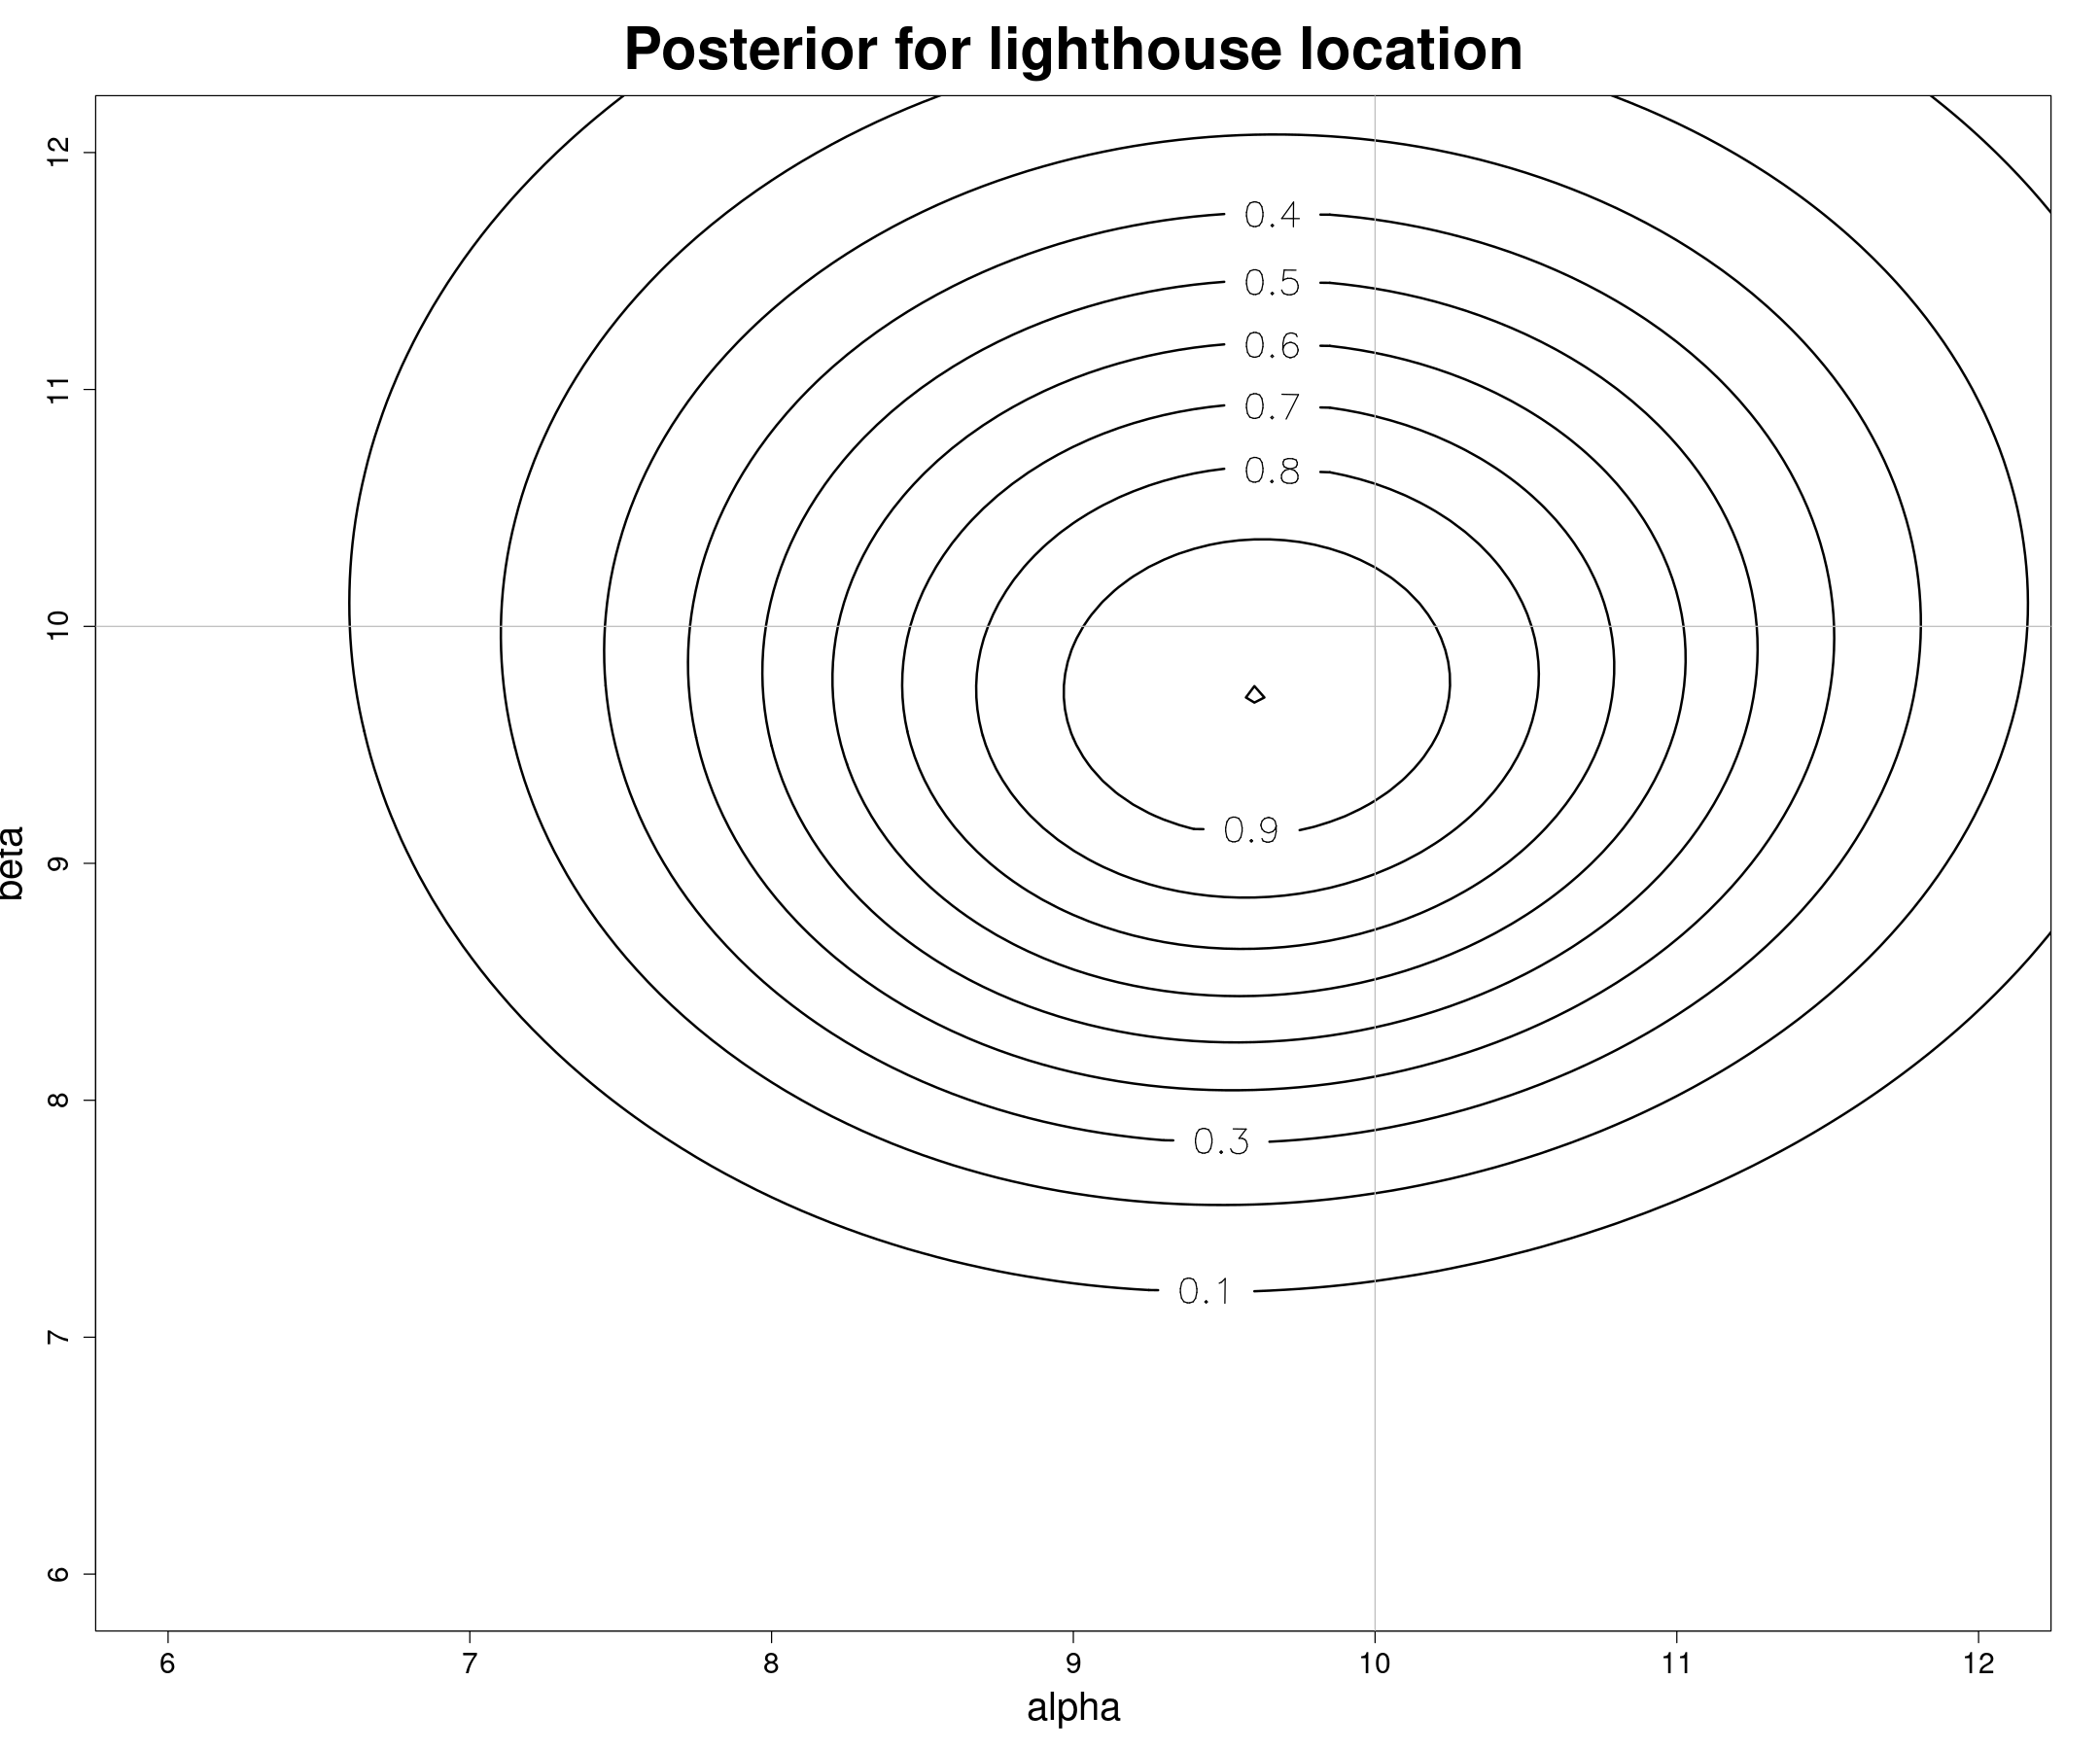

In [12]:
options(repr.plot.width=18, repr.plot.height=15)
contour(alpha, beta, exp(z),
        main = "Posterior for lighthouse location",
        xlab="alpha", ylab="beta", xlim = c(6,12),ylim=c(6,12),
        labcex = 2, lwd = 2, cex.axis = 1.5, cex.lab = 2, cex.main = 3)
abline(v=alpha.true,h=beta.true,col="grey")

## Exercise 3
• Given the Signal over Background example discussed last week, analyze and discuss the following
cases:

In [13]:
options(repr.plot.width=16, repr.plot.height=10)

set.seed(205)
signal <- function(x, A, B, x0, w, t) {t*(A*exp(-(x-x0)**2/(2*w**2)) + B)}
x0 <- 0 # Signal peak
w <-1 # Signal width
A.true <- 2 # Signal amplitude
B.true <- 1 # Background amplitude
Delta.t <- 5 # Exposure time


xdat <- seq(from = -7*w, to = 7*w, by = 0.5*w)
s.true <- signal(xdat, A.true, B.true, x0, w, Delta.t)
ddat <- rpois(length(s.true),s.true)


log.post <- function(d, x, a, b, x0, w, t) {
    if(a<0 || b <0){return(-Inf)}
    sum(dpois(d, lambda=signal(x, a, b, x0, w, t), log=TRUE))
}

As <- seq(0,5,0.01); Bs <- seq(0,5,0.01)
z <- matrix(data = NA,nrow = length(As),ncol = length(Bs))
for(i in 1:length(As)){
    for(j in 1:length(Bs)){
        z[i,j] <- log.post(ddat,xdat,As[i],Bs[j],x0,w,Delta.t)
    }
}
z <- z-max(z)


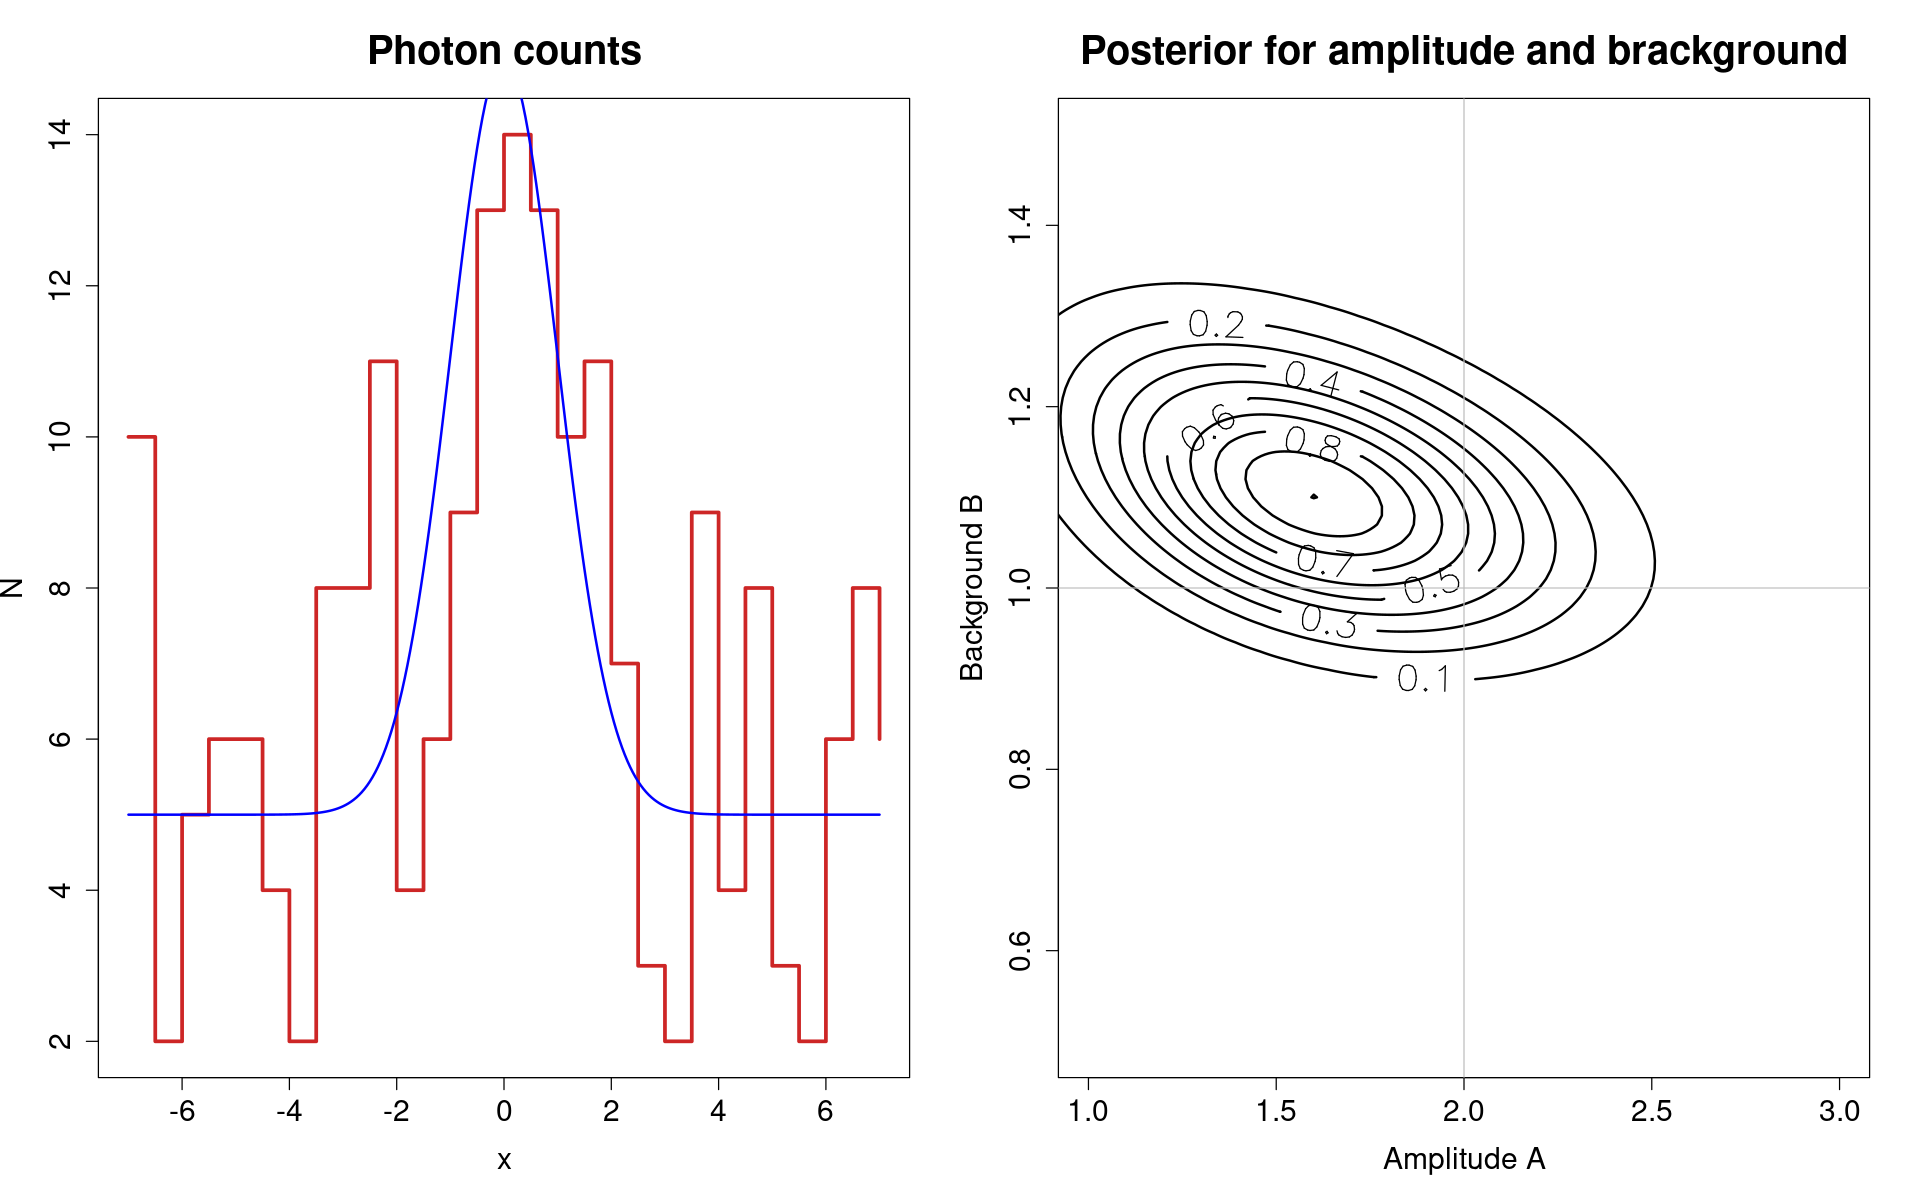

In [14]:
par(mfrow = c(1,2))

x.plot <- seq(from = -7*w, to = 7*w, by = 0.05*w)
s.plot <- signal(x.plot, A.true, B.true, x0, w, Delta.t)
plot(xdat,ddat,type = 's', lwd = 3,col = 'firebrick3',
    main = 'Photon counts',
    xlab ='x', ylab = 'N',
    cex.axis = 1.5, cex.lab = 1.5, cex.main = 2)
lines(x.plot,s.plot, type = 'l', lwd = 2, col ='blue')

contour(As, Bs, exp(z),
    main = "Posterior for amplitude and brackground",
    xlab="Amplitude A", ylab="Background B", xlim = c(1,3),ylim=c(0.5,1.5),
    labcex = 2, lwd = 2, cex.axis = 1.5, cex.lab = 1.5, cex.main = 2)
abline(v=A.true,h=B.true,col="grey")

### a ) vary the sampling resolution of used to generate the data, keeping the same sampling range 
```xdat <- seq(from=-7*w, to=7*w, by=0.5*w)}```
 - change the resolution $w = \{0.1, 0.25, 1, 2, 3\}$
 - Check the effect on the results


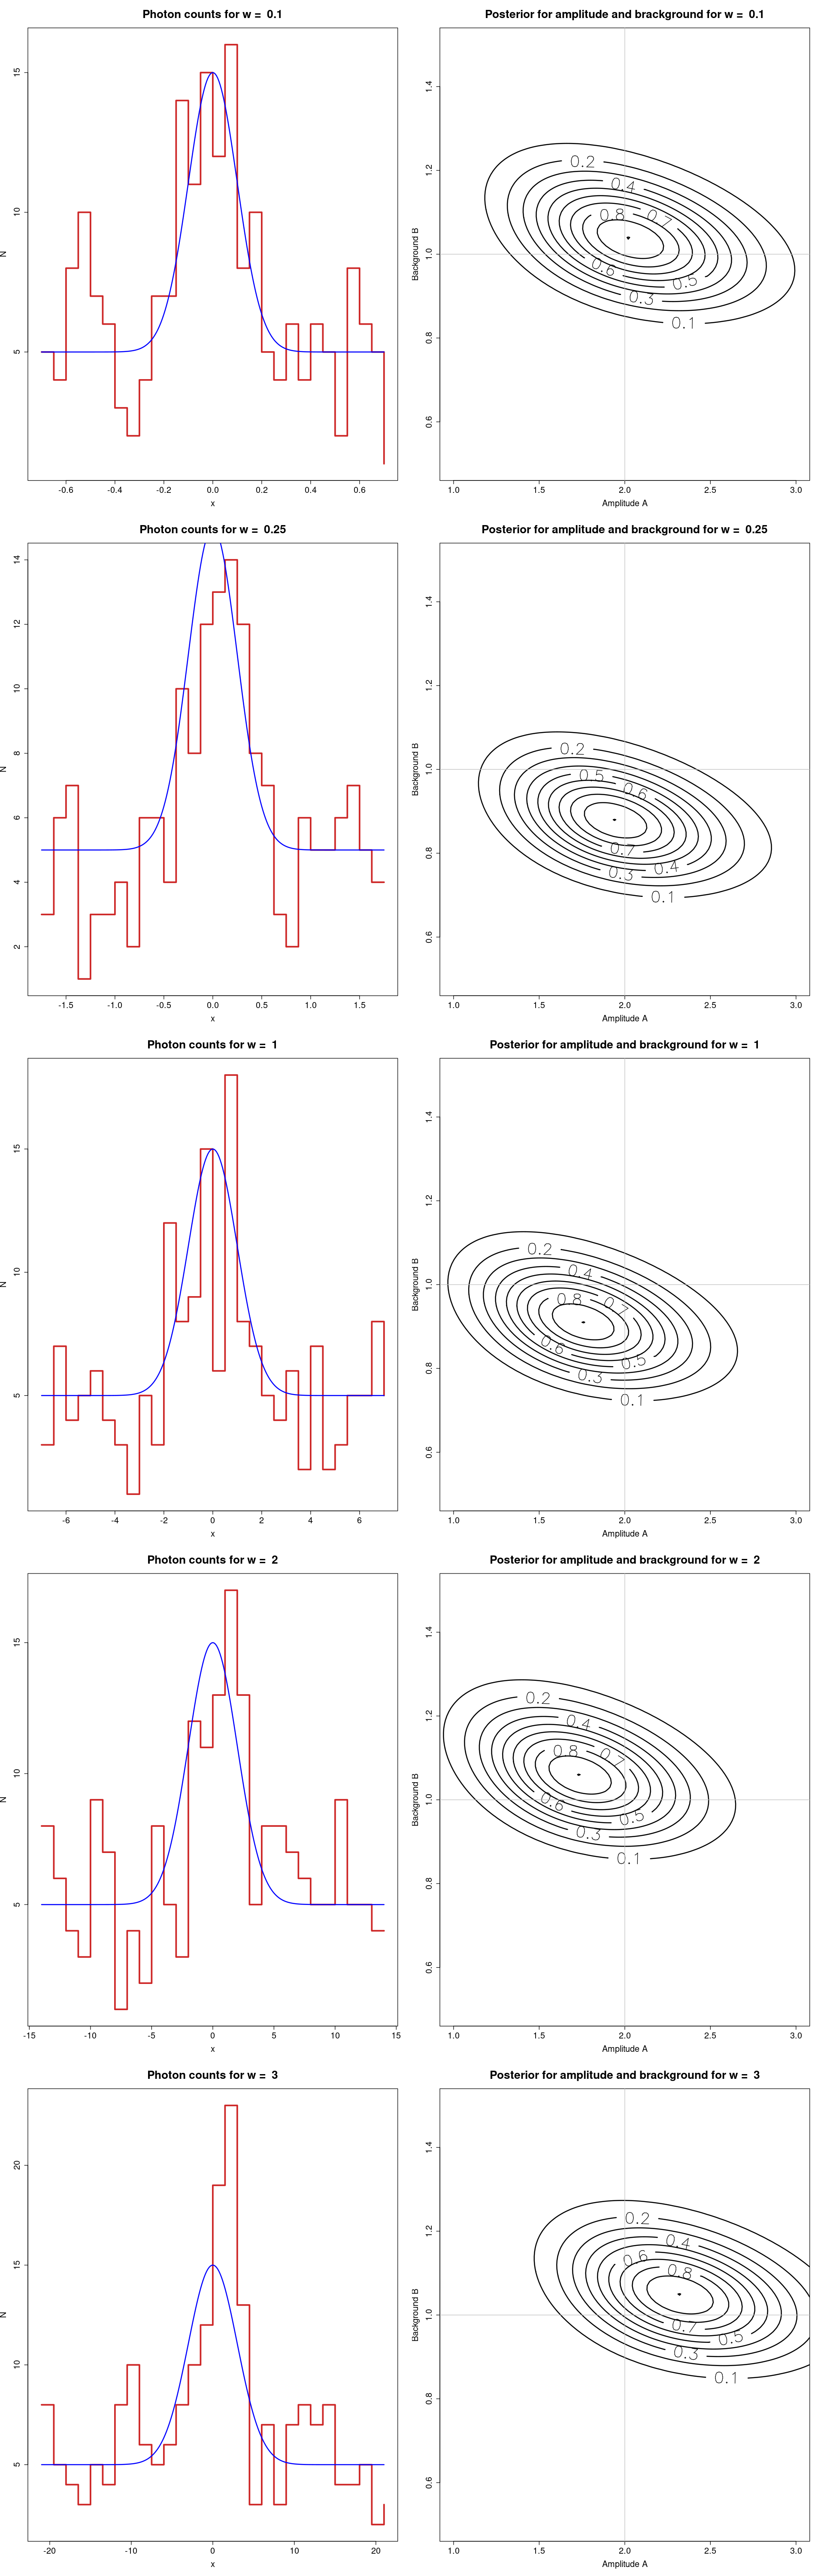

In [15]:
ws = c(0.1,0.25,1,2,3)
options(repr.plot.width=16, repr.plot.height=10*length(ws))
par(mfrow = c(length(ws),2))

for(w in ws){
    xdat <- seq(from = -7*w, to = 7*w, by = 0.5*w)
    s.true <- signal(xdat, A.true, B.true, x0, w, Delta.t)
    ddat <- rpois(length(s.true),s.true)
    z <- outer(As,Bs,Vectorize(function(A,B){log.post(ddat,xdat,A,B,x0,w,Delta.t)}))
    z <- z-max(z)

    x.plot <- seq(from = -7*w, to = 7*w, by = 0.05*w)
    s.plot <- signal(x.plot, A.true, B.true, x0, w, Delta.t)
    plot(xdat,ddat,type = 's', lwd = 3,col = 'firebrick3',
        main = paste('Photon counts for w = ',w),
        xlab ='x', ylab = 'N',
        cex.axis = 1.5, cex.lab = 1.5, cex.main = 2)
    lines(x.plot,s.plot, type = 'l', lwd = 2, col ='blue')

    contour(As, Bs, exp(z),
        main = paste("Posterior for amplitude and brackground for w = ",w),
        xlab="Amplitude A", ylab="Background B", xlim = c(1,3),ylim=c(0.5,1.5),
        labcex = 2, lwd = 2, cex.axis = 1.5, cex.lab = 1.5, cex.main = 2)
    abline(v=A.true,h=B.true,col="grey")
}

### b) change the ratio A/B used to simulate the data (keeping both positive in accordance with the prior)
 - Check the effect on the results

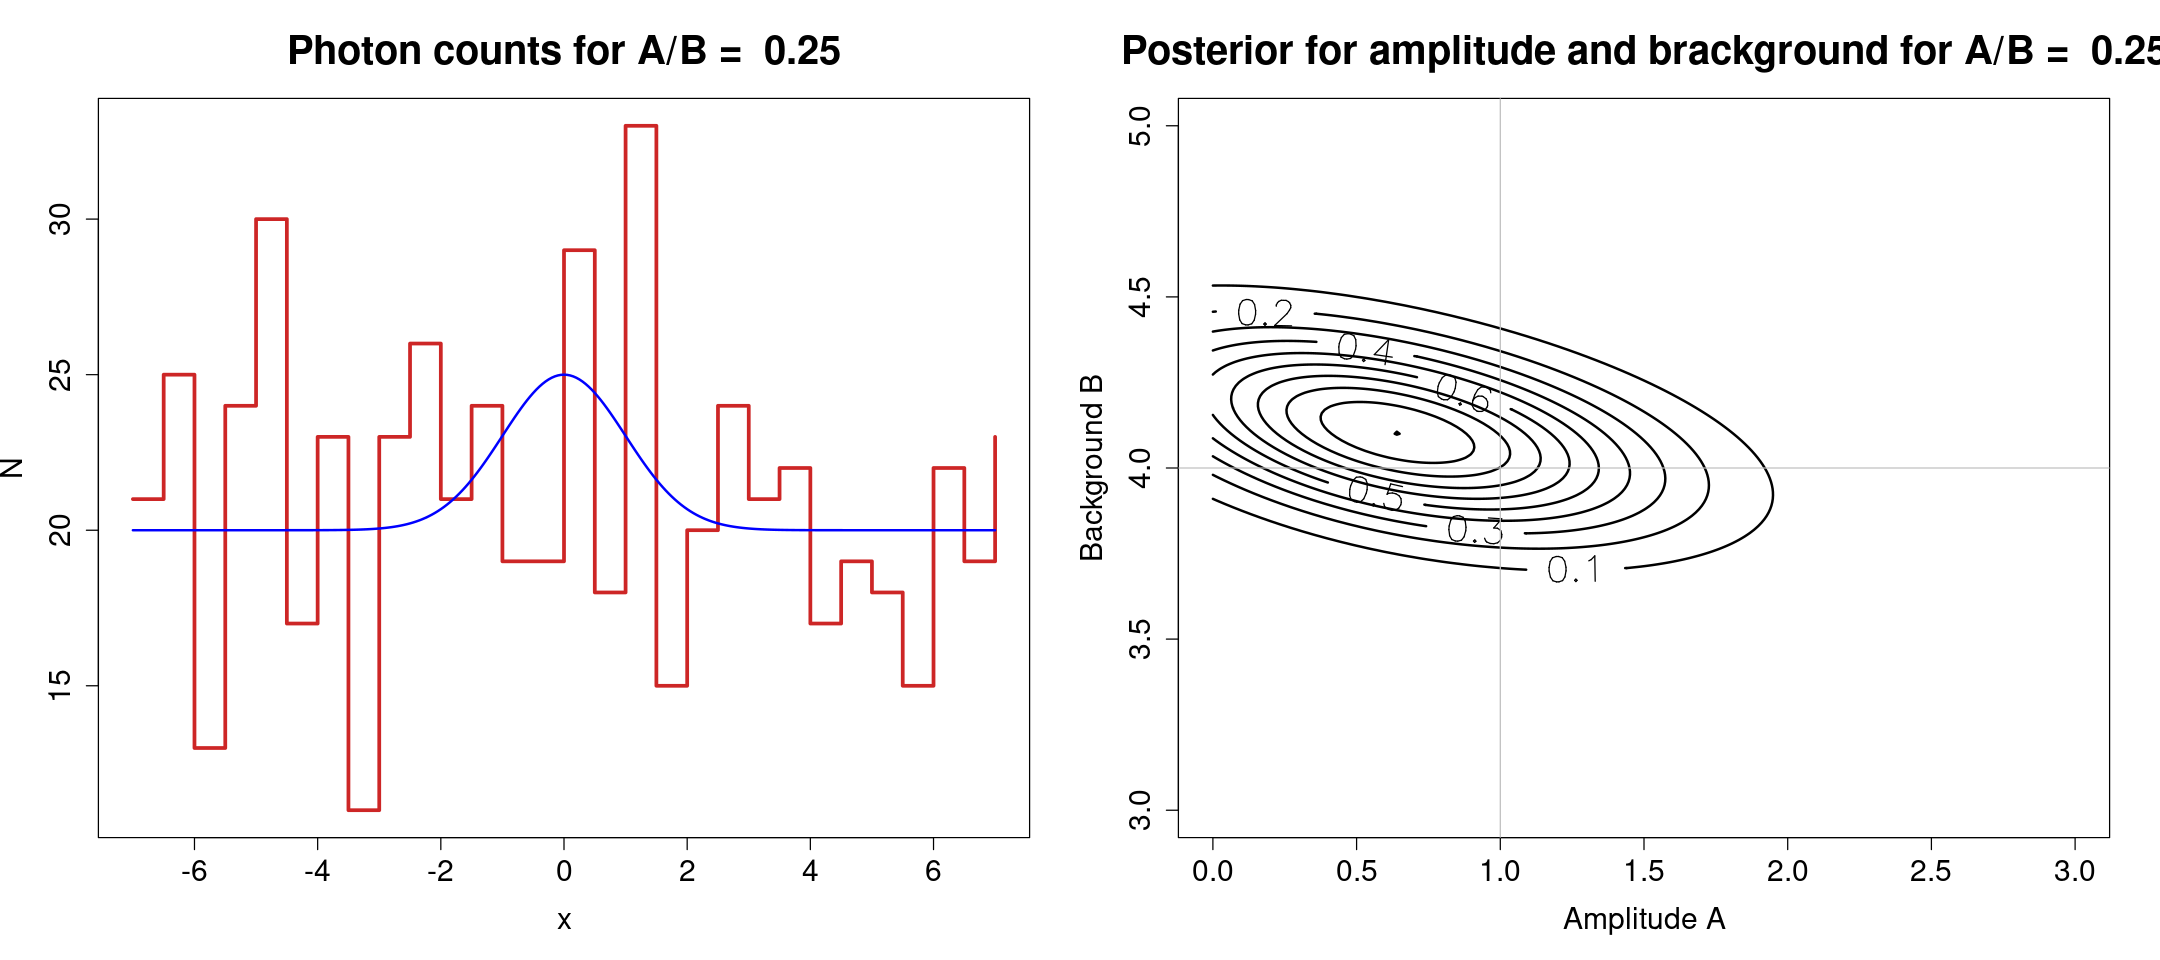

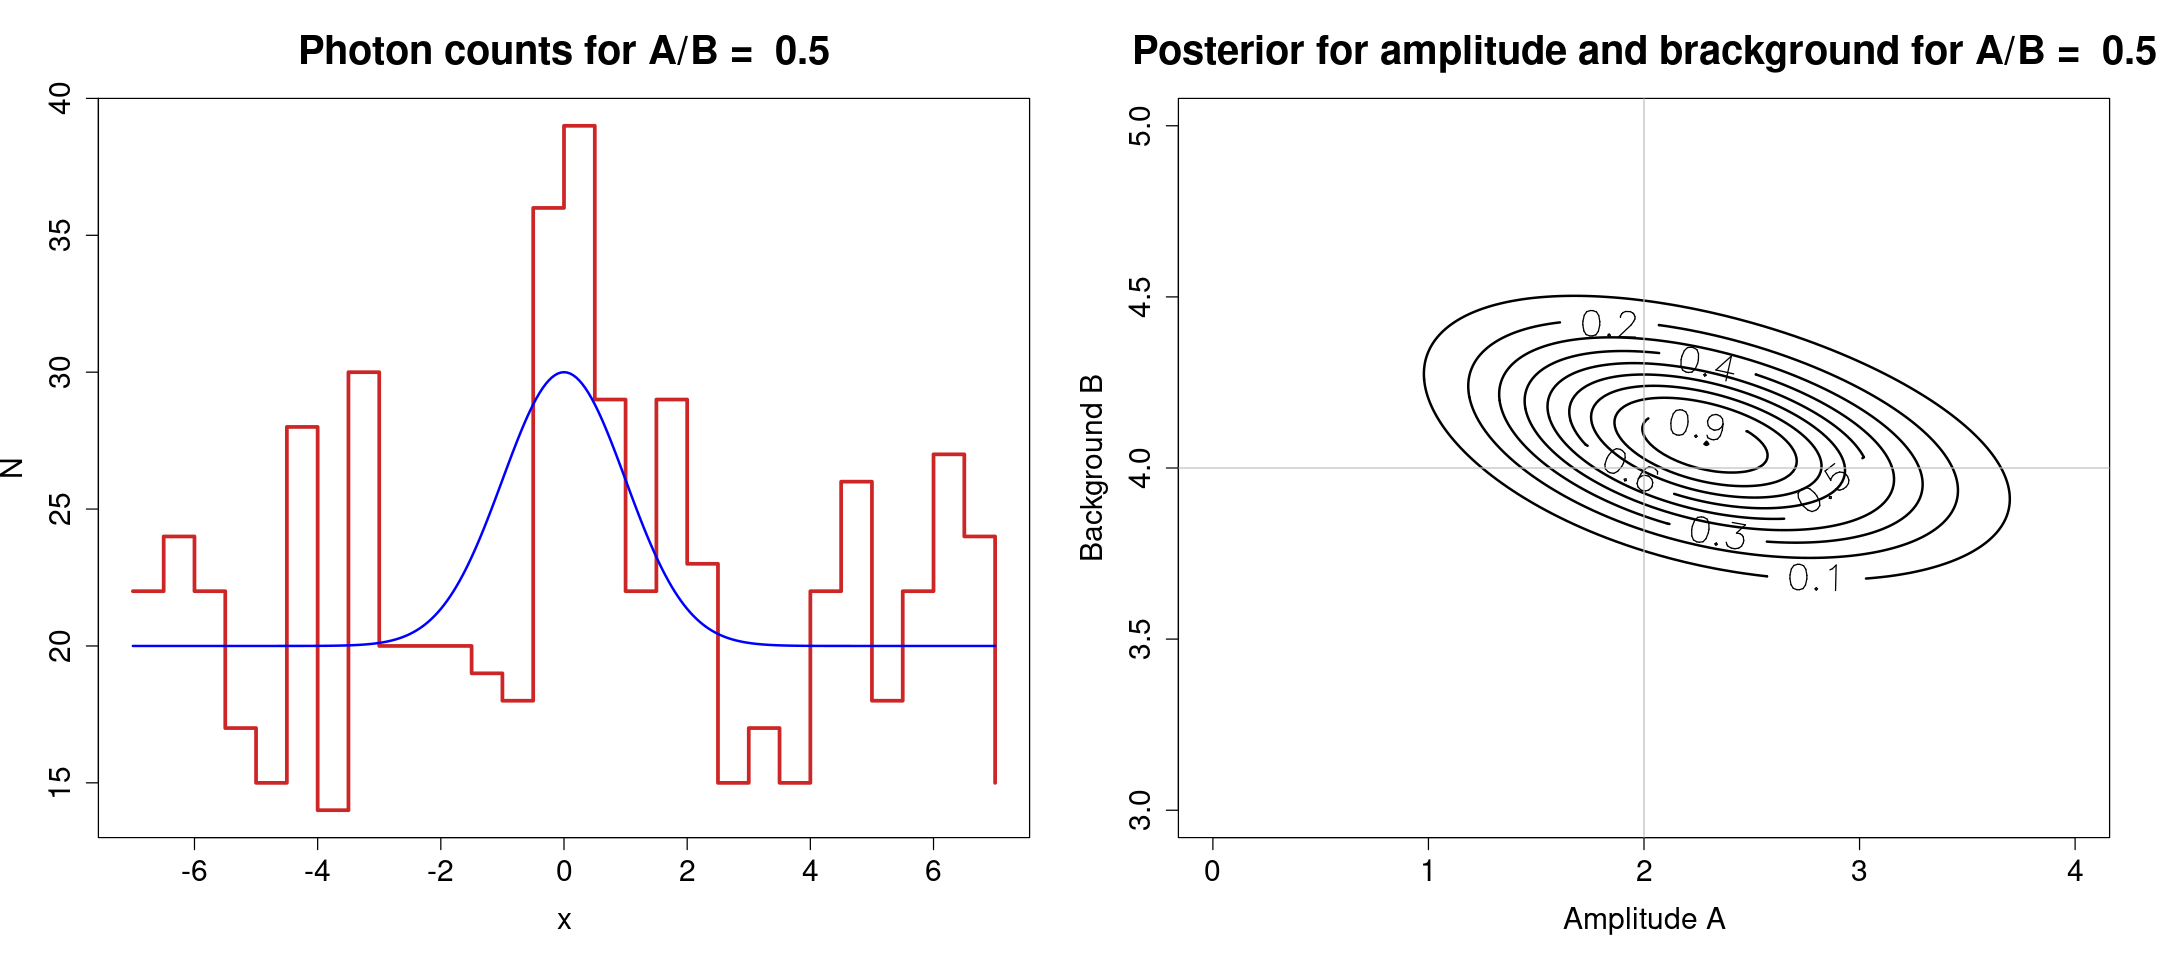

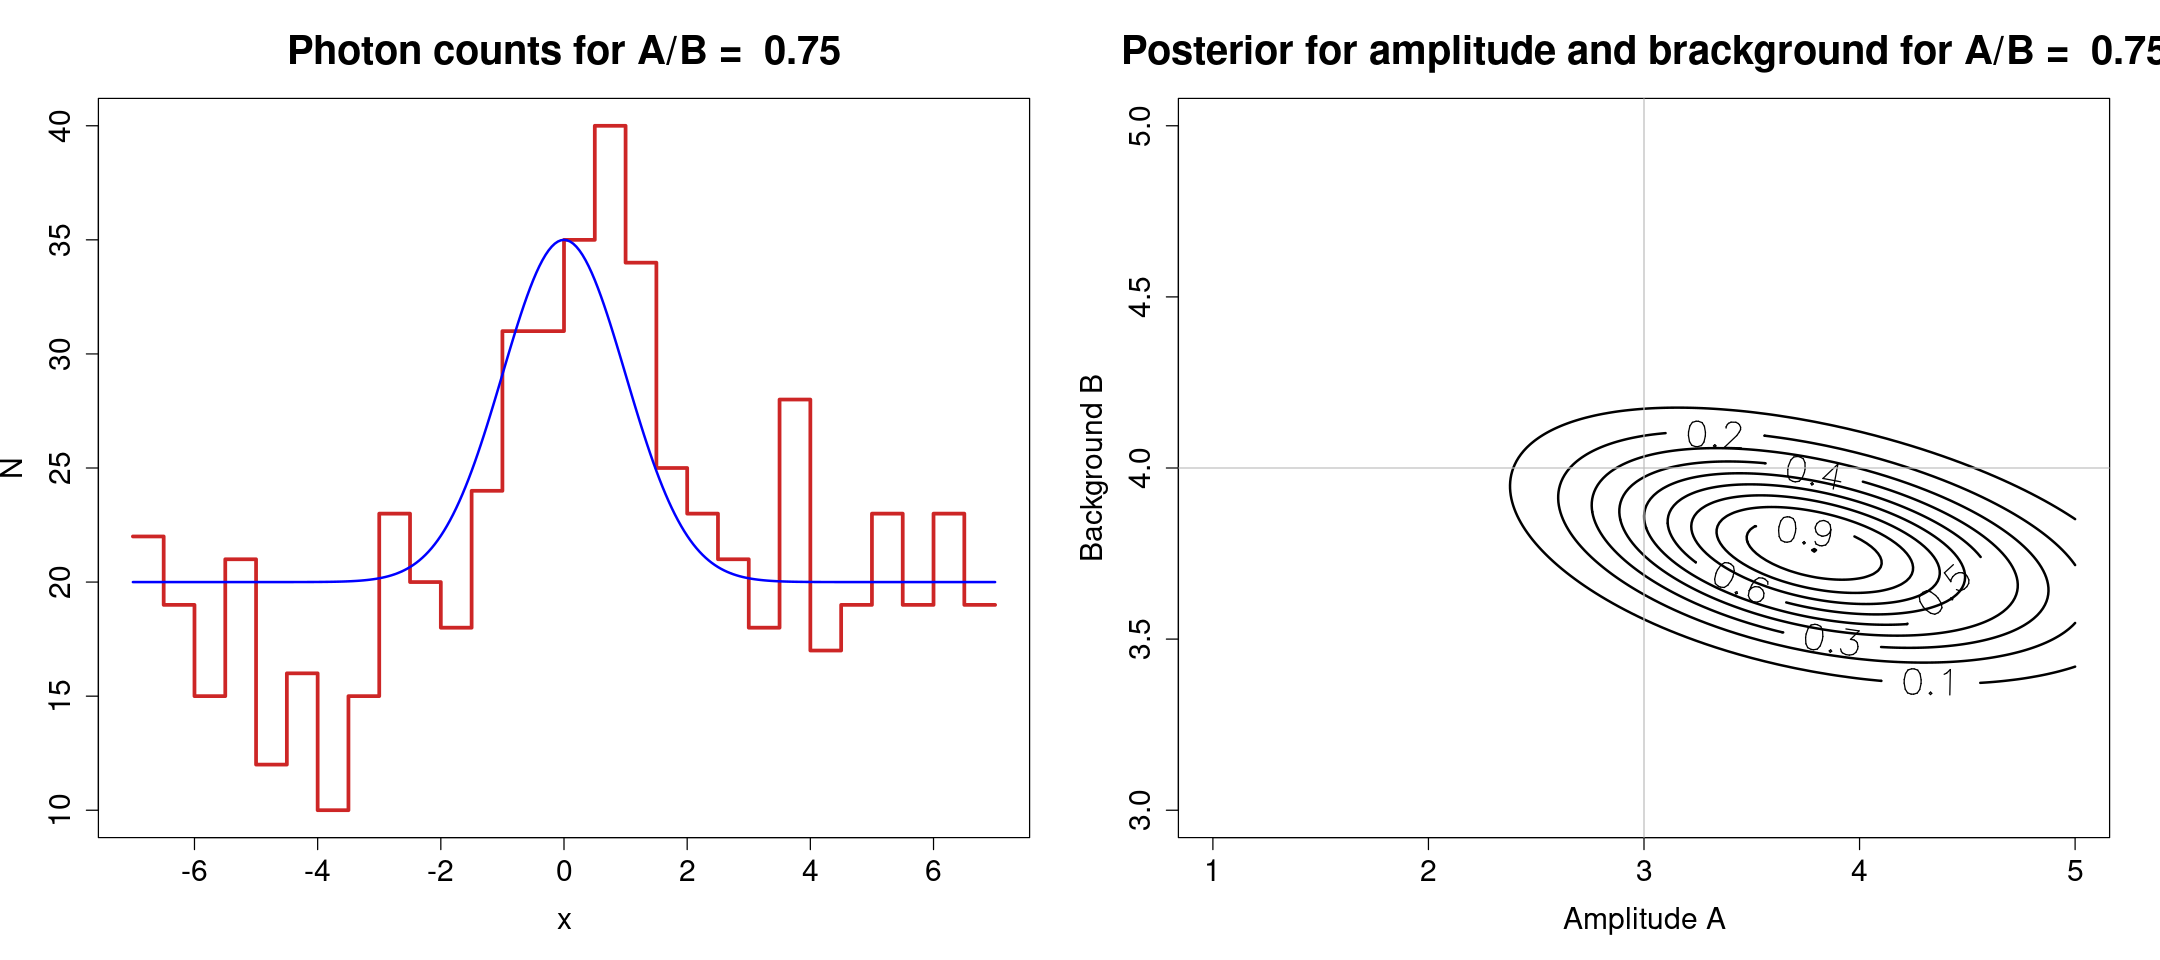

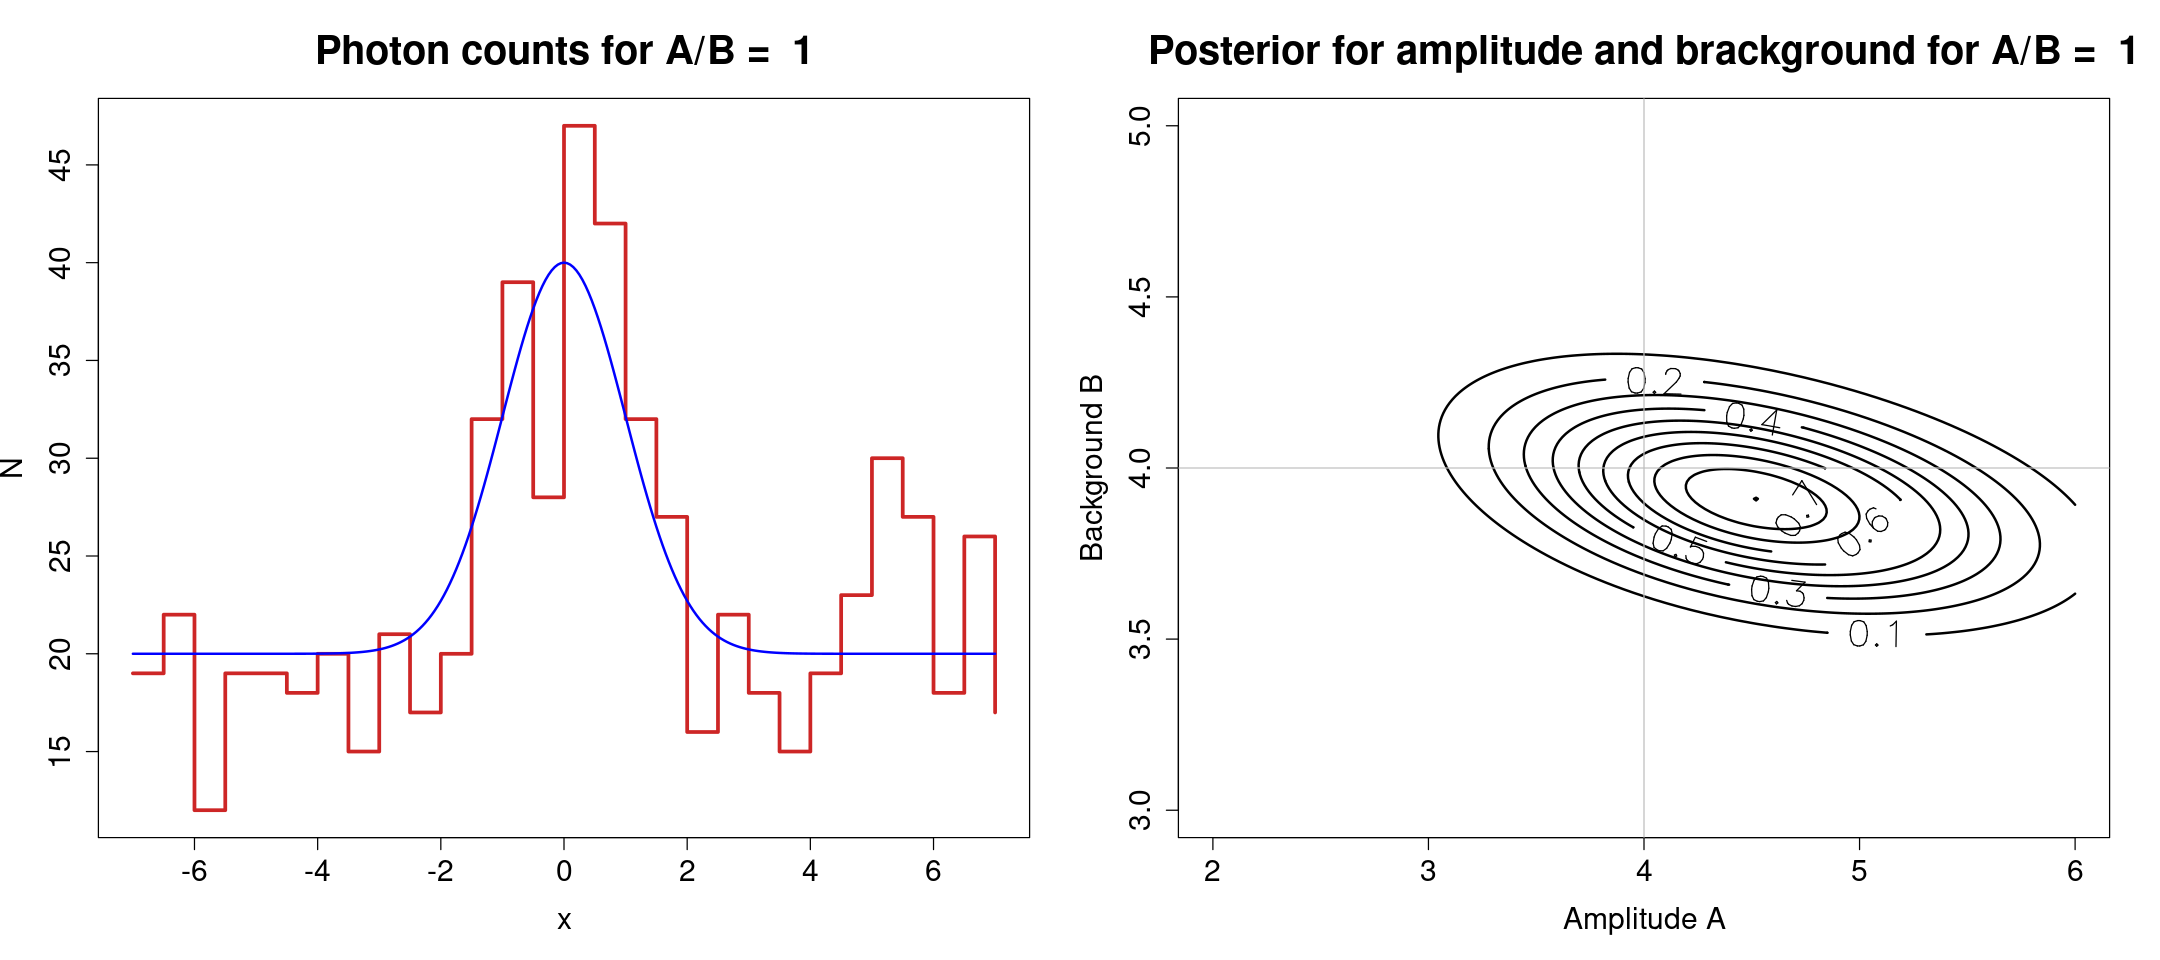

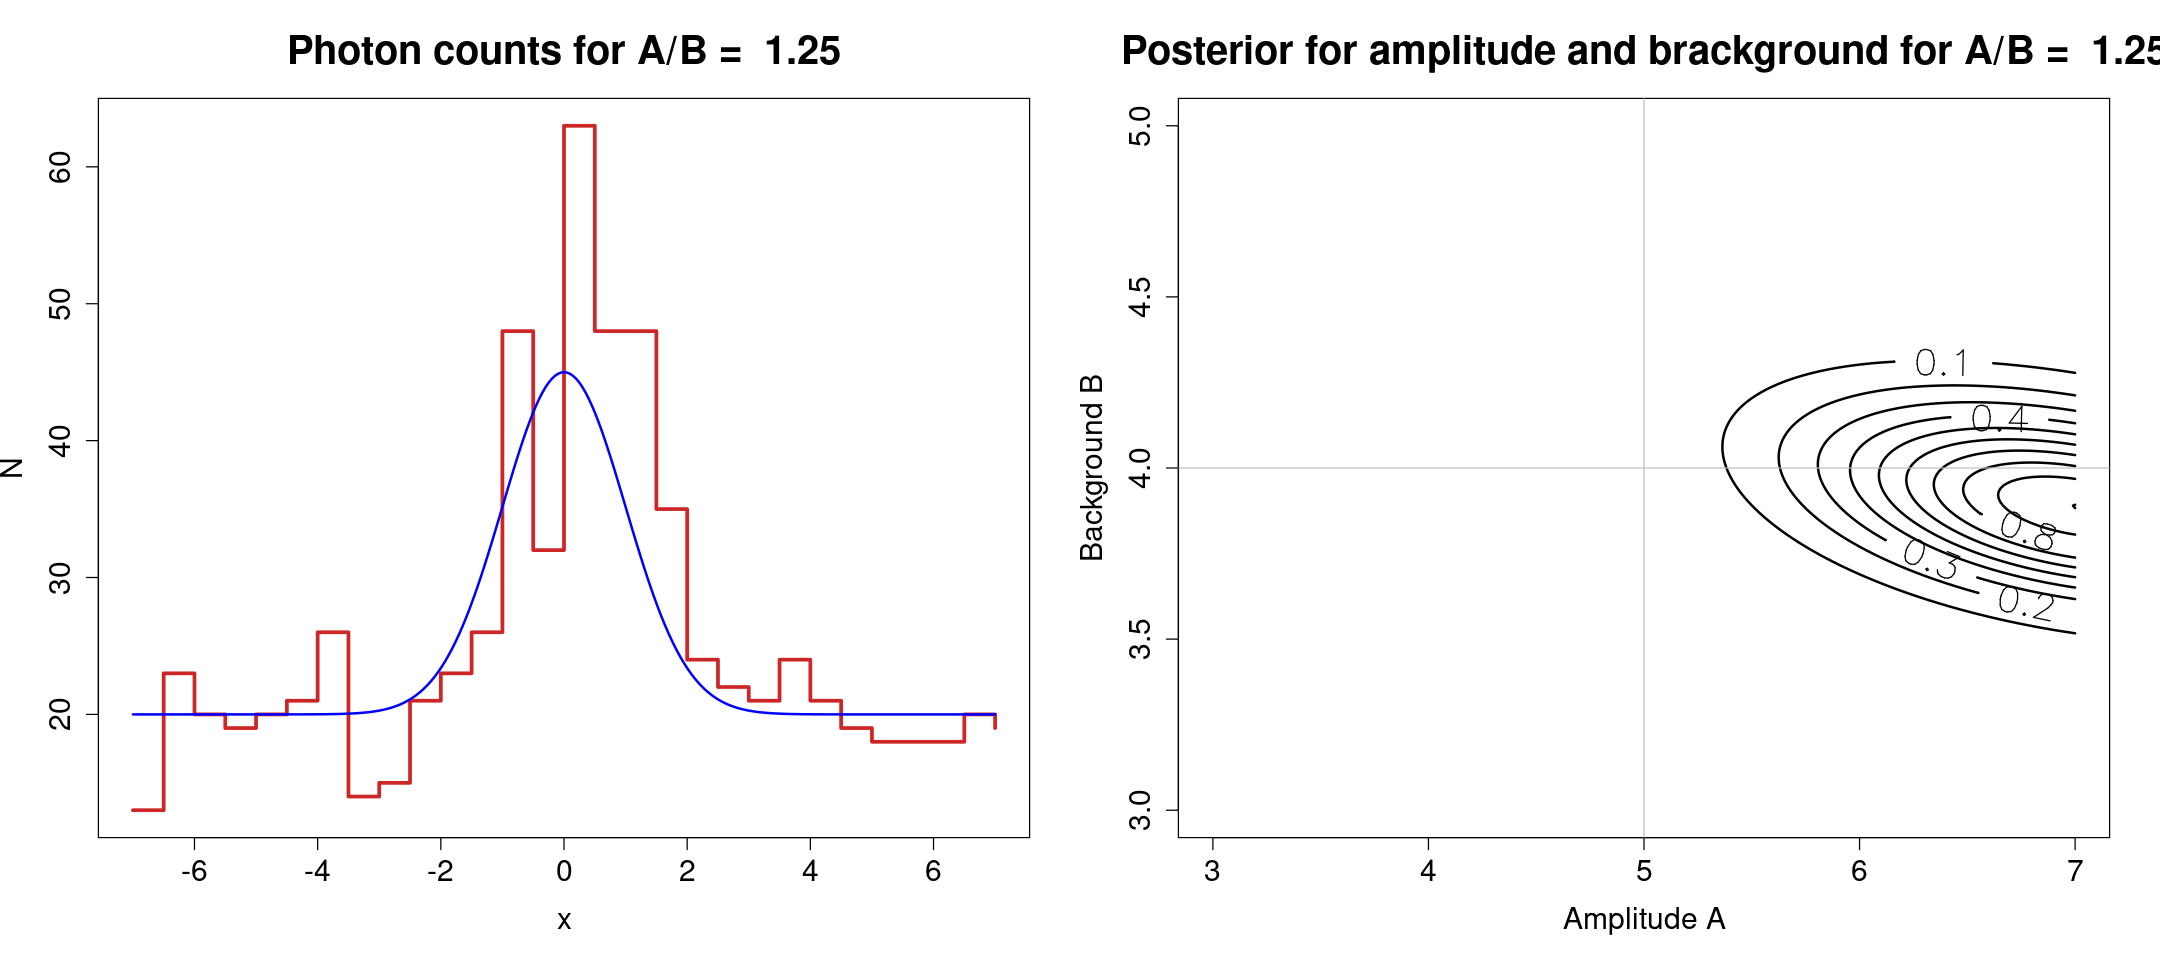

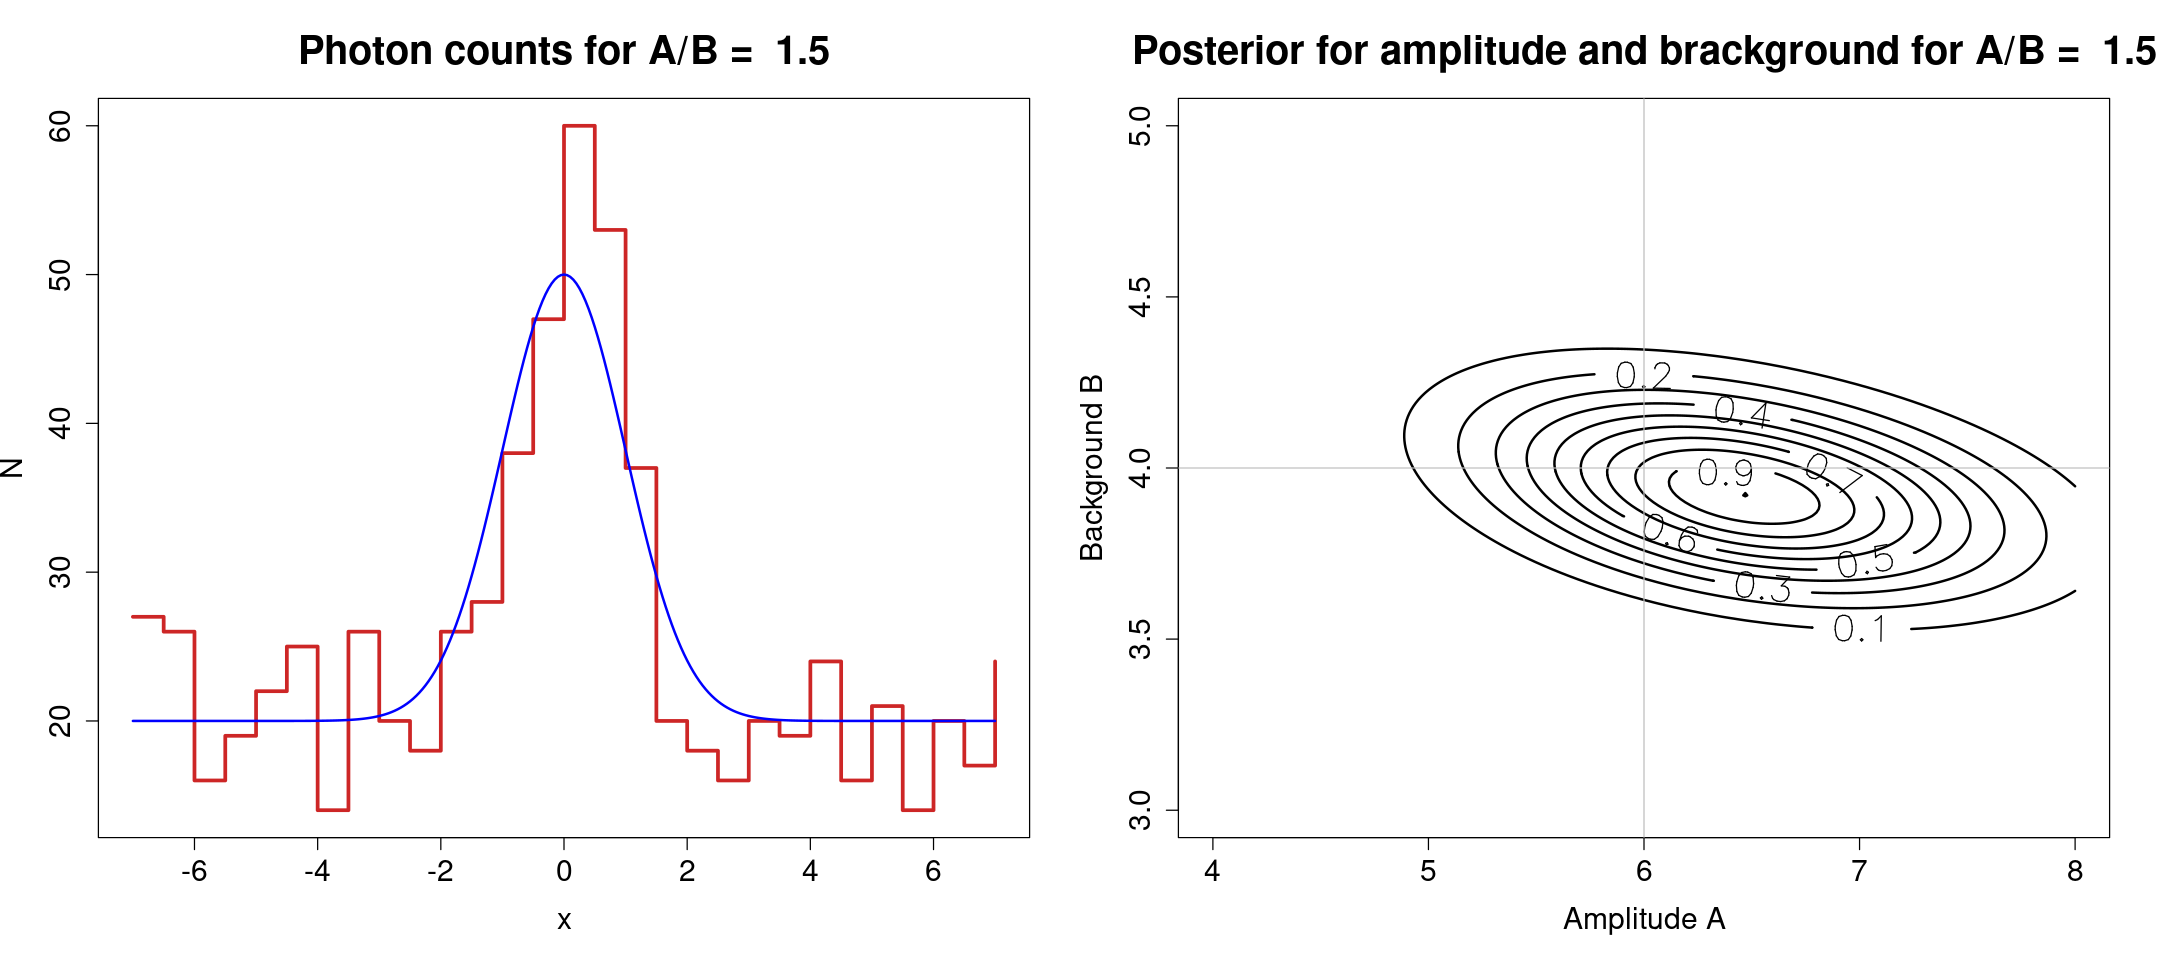

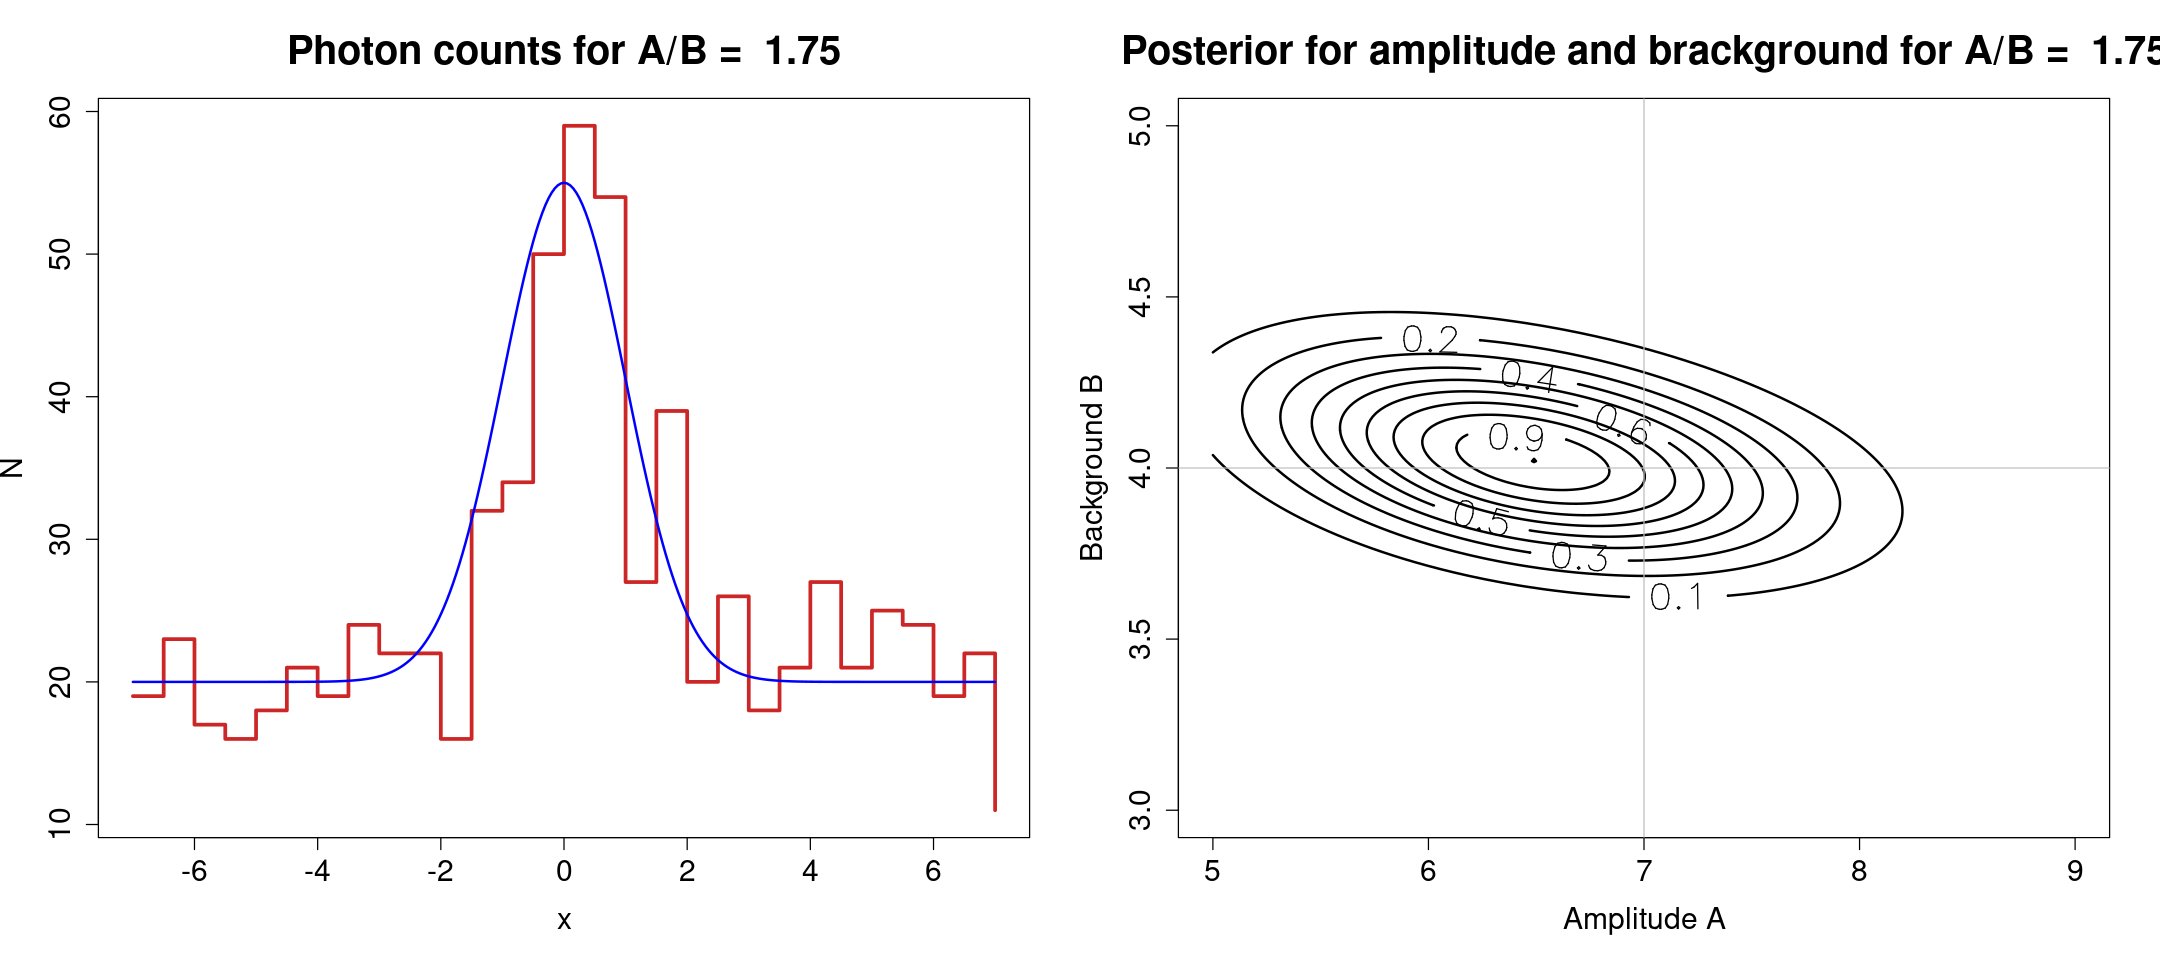

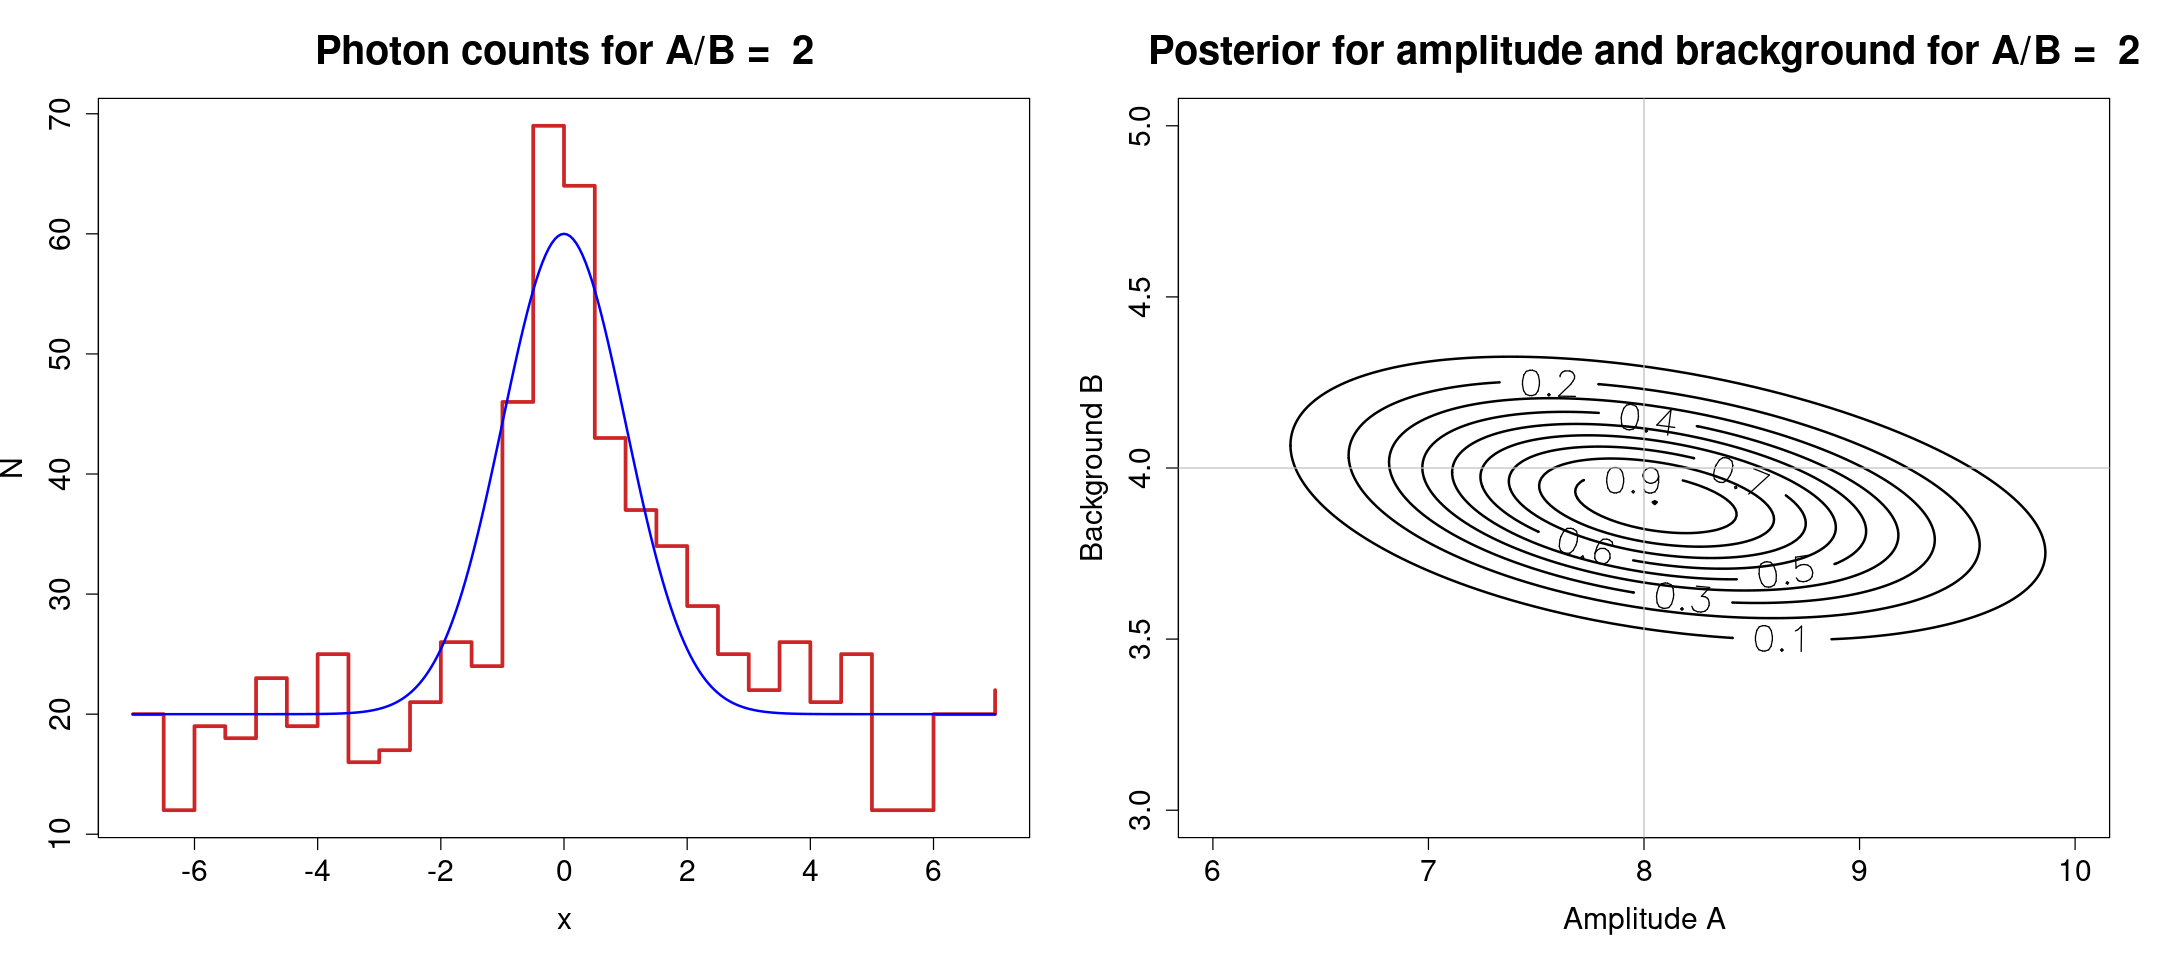

In [16]:
# Parameters
# We'll vary A and keep B fixed
A0 <- seq(1,8,1)
Bs <- seq(2,6,0.01)
B.true <- 4
x0 <- 0
Delta.t <- 5
w <- 1

# Plot settings
options(repr.plot.width=18, repr.plot.height=8)

# Analysis
for(A.true in A0){
    par(mfrow = c(1,2))
    As <- seq(max(0,A.true-2),A.true+2,0.01)
    r <- A.true/B.true
    xdat <- seq(from = -7*w, to = 7*w, by = 0.5*w)
    s.true <- signal(xdat, A.true, B.true, x0, w, Delta.t)
    ddat <- rpois(length(s.true),s.true)
    z <- outer(As,Bs,Vectorize(function(A,B){log.post(ddat,xdat,A,B,x0,w,Delta.t)}))
    z <- z-max(z)

    x.plot <- seq(from = -7*w, to = 7*w, by = 0.05*w)
    s.plot <- signal(x.plot, A.true, B.true, x0, w, Delta.t)
    plot(xdat,ddat,type = 's', lwd = 3,col = 'firebrick3',
        main = paste('Photon counts for A/B = ',r),
        xlab ='x', ylab = 'N',
        cex.axis = 1.5, cex.lab = 1.5, cex.main = 2)
    lines(x.plot,s.plot, type = 'l', lwd = 2, col ='blue')

    contour(As, Bs, exp(z),
        main = paste("Posterior for amplitude and brackground for A/B = ",r),
        xlab="Amplitude A", ylab="Background B", xlim = c(max(A.true-2,0),A.true+2),ylim=c(B.true-1,B.true+1),
        labcex = 2, lwd = 2, cex.axis = 1.5, cex.lab = 1.5, cex.main = 2)
    abline(v=A.true,h=B.true,col="grey")
}